## Airline Customer Experience Analysis and Satisfaction Prediction

### Introduction

#### Dataset

We will use the “Customer Satisfaction in Airline” dataset from [OpenML](https://www.openml.org/search?type=data&status=active&id=46920&sort=runs) (≈130,000 observations × 22 features). It includes detailed information about travel characteristics, service ratings, and overall satisfaction labels.

#### Motivation

This dataset provides a realistic and multifaceted view of airline customer experiences. In a highly competitive industry, understanding satisfaction drivers is essential for improving service quality, retaining customers, and guiding business strategies. We selected this dataset because:

- **Strong business relevance:** Predicting and explaining satisfaction drivers supports data-driven decision-making.
- **Large & Comprehensive sample:** Over 130,000 observations enable robust modeling and insight generation.
- **Holistic coverage of the customer journey:** The dataset allows exploration across several service dimensions, from gate to inflight experience.

#### Project Objectives

1. Exploratory Data Analysis *(EDA)*

Perform an initial analysis to:

- Examine data distributions and detect outliers or inconsistencies.
- Identify correlations between service features *(e.g., in-flight comfort, flight distance, gate location)* and satisfaction.
- Visualize trends and behaviors to reveal preliminary insights.

2. Predictive Modeling of Customer Satisfaction

Develop and evaluate models to predict customer satisfaction, comparing:

- **Logistic Regression:** Baseline model emphasizing interpretability.
- **Tree-based models:** Random Forest, Gradient Boosting, and XGBoost, capable of capturing nonlinear relationships.

Model performance will be evaluated using accuracy, ROC-AUC, and F1-score. Interpretability tools such as feature importance or SHAP values will help identify the primary satisfaction drivers.

3. Customer Segmentation *(Clustering)*

Complement the predictive approach with unsupervised learning to identify distinct customer profiles. Techniques such as K-Means or Hierarchical Clustering will be applied to uncover segments like:

- Promoters *(high satisfaction)*
- Passive or neutral customers
- Detractors *(low satisfaction)*

This segmentation will enhance understanding of customer heterogeneity and support targeted marketing or operational strategies.

In [ ]:
#!pip install -r requirements.txt

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Part 1 - Exploratory Data Analysis *(EDA)*

#### Import

In [4]:
import os
import openml
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder

#### Loading the Dataset

In [5]:
# Download dataset from OpenML
dataset_id = 46920
dataset = openml.datasets.get_dataset(dataset_id)

#  Retrieve features (X), target (y), categorical info, and attribute names
X_raw, y_raw, categorical_indicator, attribute_names = dataset.get_data(
    target=dataset.default_target_attribute
)

df = pd.DataFrame(X_raw, columns=attribute_names)
df['satisfaction'] = y_raw

# Display the first rows
display(df.head())

,CustomerType,Age,TypeofTravel,Class,FlightDistance,Seatcomfort,DepartureArrivaltimeconvenient,Foodanddrink,Gatelocation,Inflightwifiservice,...,EaseofOnlinebooking,Onboardservice,Legroomservice,Baggagehandling,Checkinservice,Cleanliness,Onlineboarding,DepartureDelayinMinutes,ArrivalDelayinMinutes,satisfaction
0,disloyal Customer,20,Business travel,Eco,2069,4,4,4,3,5,...,5,4,5,3,2,4,5,0,7.0,dissatisfied
1,Loyal Customer,48,Personal Travel,Eco,2329,2,4,2,3,1,...,1,1,5,3,1,2,1,0,0.0,dissatisfied
2,Loyal Customer,24,Business travel,Eco,1273,1,1,0,3,5,...,5,2,2,2,2,2,5,0,8.0,dissatisfied
3,disloyal Customer,28,Business travel,Business,2306,4,4,4,1,3,...,3,4,5,5,4,4,3,72,80.0,satisfied
4,Loyal Customer,49,Business travel,Business,1545,4,4,4,4,3,...,5,5,5,5,5,5,3,0,0.0,satisfied


#### Data Profiling

In order to effectively structure and guide our exploratory data analysis *(EDA)*, we begin by conducting an in-depth data profiling of the dataset.

In [6]:
# Check if DataFrame is not empty
if df.empty:
    raise ValueError("DataFrame is empty. Cannot generate profiling report.")

# Generate the profiling report
profile = ProfileReport(
    df,
    title="Airline Customer Satisfaction Profiling Report",
    html={"style": {"full_width": True}},
    minimal=True,
    sort=None,
    progress_bar=False
)

# Define the output file path
output_file_name = "data_profile_report.html"
output_file_path = os.path.abspath(output_file_name)

# Save the report
profile.to_file(output_file_path)
print(f"Profiling report successfully saved!")


100%|██████████| 22/22 [00:00<00:00, 444.75it/s]


Profiling report successfully saved!


#### Basic Exploration

We begin with a descriptive exploration of the dataset in order to understand its main characteristics.

In [7]:
# Display dataset shape
n_rows, n_cols = df.shape
print(f"Dataset shape: {n_rows} rows × {n_cols} columns")

Dataset shape: 129880 rows × 22 columns


In [8]:
# Display column names
print("Column names:")
display(df.columns)

Column names:


Index(['CustomerType', 'Age', 'TypeofTravel', 'Class', 'FlightDistance',
       'Seatcomfort', 'DepartureArrivaltimeconvenient', 'Foodanddrink',
       'Gatelocation', 'Inflightwifiservice', 'Inflightentertainment',
       'Onlinesupport', 'EaseofOnlinebooking', 'Onboardservice',
       'Legroomservice', 'Baggagehandling', 'Checkinservice', 'Cleanliness',
       'Onlineboarding', 'DepartureDelayinMinutes', 'ArrivalDelayinMinutes',
       'satisfaction'],
      dtype='object')

In [9]:
# Data types
print("Data types:")
display(df.dtypes)

Data types:


CustomerType                      category
Age                                  uint8
TypeofTravel                      category
Class                             category
FlightDistance                       int64
Seatcomfort                       category
DepartureArrivaltimeconvenient    category
Foodanddrink                      category
Gatelocation                      category
Inflightwifiservice               category
Inflightentertainment             category
Onlinesupport                     category
EaseofOnlinebooking               category
Onboardservice                    category
Legroomservice                    category
Baggagehandling                   category
Checkinservice                    category
Cleanliness                       category
Onlineboarding                       uint8
DepartureDelayinMinutes              int64
ArrivalDelayinMinutes              float64
satisfaction                      category
dtype: object

#### Preprocessing

With the help of the information gathered through profiling and preliminary exploration, we will begin preprocessing our data.

In [10]:
# Binary columns to encode (including the target)
categorical_binary_cols = ['satisfaction', 'CustomerType', 'TypeofTravel']

for col in categorical_binary_cols:
    if col in df.columns:
        le = LabelEncoder()
        # Convert to string to avoid issues with mixed types
        df[col] = le.fit_transform(df[col].astype(str))
        print(f"Column '{col}' encoded. Classes: {list(le.classes_)}")
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

Column 'satisfaction' encoded. Classes: ['dissatisfied', 'satisfied']
Column 'CustomerType' encoded. Classes: ['Loyal Customer', 'disloyal Customer']
Column 'TypeofTravel' encoded. Classes: ['Business travel', 'Personal Travel']


In [11]:
# Display the number of unique values for each binary categorical column
display(df[categorical_binary_cols].nunique())

satisfaction    2
CustomerType    2
TypeofTravel    2
dtype: int64

In [12]:
# This creates separate binary columns for each category in 'Class'
# The prefix 'Class_' is added to the new columns for clarity
df = pd.get_dummies(df, columns=["Class"], prefix="Class", drop_first=False)

# Display the first 5 rows of the newly created one-hot columns
print(df.filter(like="Class_").head())

   Class_Business  Class_Eco  Class_Eco Plus
0           False       True           False
1           False       True           False
2           False       True           False
3            True      False           False
4            True      False           False


Ordinal variables group together columns associated with `flight factors`, which describe characteristics specific to the airline.

In [13]:
# List of ordinal features to convert to numeric
ordinal_features = [
    'Onlineboarding', 'Seatcomfort', 'DepartureArrivaltimeconvenient', 'Foodanddrink',
    'Gatelocation', 'Inflightwifiservice', 'Inflightentertainment', 'Onlinesupport',
    'EaseofOnlinebooking', 'Onboardservice', 'Legroomservice', 'Baggagehandling',
    'Checkinservice', 'Cleanliness'
]

# Convert each ordinal feature to numeric type with nullable integer support
for col in ordinal_features:
    if col in df.columns:
        # Convert values to numeric, coercing errors to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # Convert to pandas nullable integer type to preserve missing values
        df[col] = df[col].astype('Int64')
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

# Display the data types to confirm conversion
print(df[ordinal_features].dtypes)

Onlineboarding                    Int64
Seatcomfort                       Int64
DepartureArrivaltimeconvenient    Int64
Foodanddrink                      Int64
Gatelocation                      Int64
Inflightwifiservice               Int64
Inflightentertainment             Int64
Onlinesupport                     Int64
EaseofOnlinebooking               Int64
Onboardservice                    Int64
Legroomservice                    Int64
Baggagehandling                   Int64
Checkinservice                    Int64
Cleanliness                       Int64
dtype: object


In [14]:
# Calculate missing values for each column
total_rows = len(df)
missing_count = df.isnull().sum()
missing_percentage = (missing_count / total_rows) * 100

# Create a summary DataFrame
missing_report = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage (%)': missing_percentage.round(2)
})

# Keep only columns with missing values, sorted by descending count
missing_report = missing_report[missing_report['Missing Count'] > 0] \
                                .sort_values(by='Missing Count', ascending=False)

# Display the missing values report
print(missing_report)

                       Missing Count  Missing Percentage (%)
ArrivalDelayinMinutes            393                     0.3


Given the right-skewed distribution *(positive skewness)* of the `ArrivalDelayinMinutes` variable, we chose to impute the missing values using the median in order to limit the bias caused by the presence of outliers.

In [15]:
# Impute missing values in 'ArrivalDelayinMinutes' with the median
median_delay = df['ArrivalDelayinMinutes'].median()
df['ArrivalDelayinMinutes'] = df['ArrivalDelayinMinutes'].fillna(median_delay)

# Verify that no missing values remain
missing_after_impute = df['ArrivalDelayinMinutes'].isnull().sum()
print(f"Number of missing values after imputation: {missing_after_impute}")


Number of missing values after imputation: 0


#### Data Analysis

We now turn to the heart of the analysis, namely the in-depth study of the data and its visualisation.

In [16]:
# Display summary statistics
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
CustomerType,129880.0,0.183092,0.386743,0.0,0.0,0.0,0.0,1.0
Age,129880.0,39.427957,15.11936,7.0,27.0,40.0,51.0,85.0
TypeofTravel,129880.0,0.309416,0.462255,0.0,0.0,0.0,1.0,1.0
FlightDistance,129880.0,1981.409055,1027.115606,50.0,1359.0,1925.0,2544.0,6951.0
Seatcomfort,129880.0,2.838597,1.392983,0.0,2.0,3.0,4.0,5.0
DepartureArrivaltimeconvenient,129880.0,2.990645,1.527224,0.0,2.0,3.0,4.0,5.0
Foodanddrink,129880.0,2.851994,1.443729,0.0,2.0,3.0,4.0,5.0
Gatelocation,129880.0,2.990422,1.30597,0.0,2.0,3.0,4.0,5.0
Inflightwifiservice,129880.0,3.24913,1.318818,0.0,2.0,3.0,4.0,5.0
Inflightentertainment,129880.0,3.383477,1.346059,0.0,2.0,4.0,4.0,5.0


A few notable observations emerge from the descriptive statistics:

- **Customer Type & Travel Type:** Only 18% of passengers are classified as business travelers *(CustomerType)*, while approximately 31% are on business trips *(TypeofTravel)*, indicating a mix of occasional business travelers in the dataset.

- **Age Distribution:** The average passenger age is approximately 39 years, with a wide range from 7 to 85 years. The median age is 40, suggesting a fairly balanced distribution, though younger travelers may be underrepresented.

- **Flight Distance:** The mean flight distance is roughly 1,981 miles, with a maximum of 6,951 miles, highlighting a mix of short and long-haul flights.

- **Satisfaction-Related Features:** Most service attributes, including seat comfort, food and drink, onboard service, and legroom, have mean ratings around 3–3.7 on a 0–5 scale, suggesting moderately positive perceptions. Notably, Baggage handling and Cleanliness have slightly higher averages *(~3.7)*, indicating that passengers are generally satisfied with these aspects.

- **In-Flight Entertainment & Online Services:** Features such as inflight entertainment, inflight WiFi, online support, and ease of online booking exhibit slightly lower averages *(~3.25–3.5)* with higher standard deviations *(~1.3)*, reflecting a greater variability in passenger experiences and potentially polarizing perceptions between different age or travel groups.

- **Delays:** Both DepartureDelayinMinutes and ArrivalDelayinMinutes are highly skewed, with medians at 0 but maximum delays exceeding 1,500 minutes. This skew suggests that while most flights are on time, a few extreme delays could significantly affect passenger satisfaction.

- **Overall Satisfaction:** Approximately 54.7% of passengers report satisfaction *(satisfaction = 1)*, indicating a fairly balanced split between satisfied and dissatisfied passengers, which is useful for modeling and comparative analysis.

The combination of moderately high service ratings and skewed delay distributions suggests that passenger satisfaction may be more sensitive to extreme service failures or delays than to average service performance. Additionally, online and entertainment-related features show high variability, pointing to potential areas for improvement that could have a meaningful impact on overall satisfaction, particularly among younger passengers.

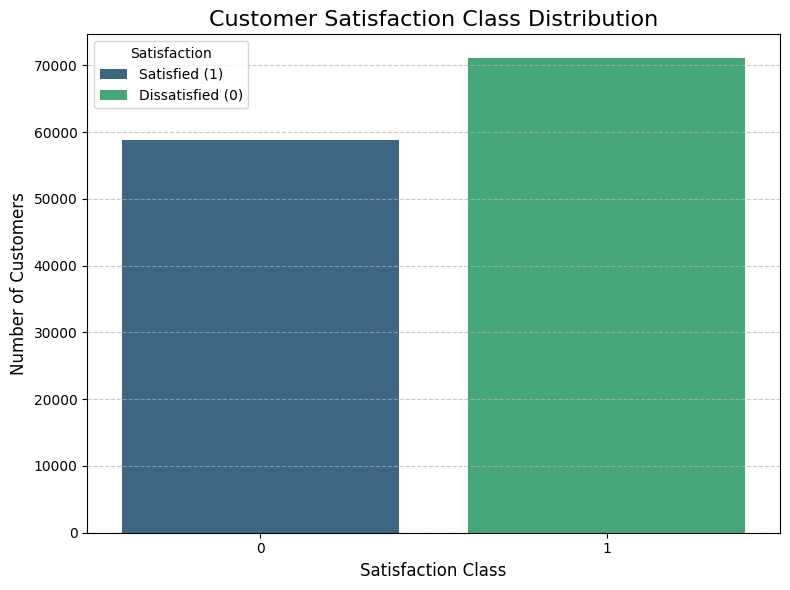

In [17]:
plt.figure(figsize=(8, 6))

# Plot the distribution of the target variable 'satisfaction'
# Use 'hue' to assign color and disable redundant legend
sns.countplot(
    x='satisfaction',
    data=df,
    palette='viridis',
    hue='satisfaction',
    legend=False
)

# Add clear titles and axis labels
plt.title('Customer Satisfaction Class Distribution', fontsize=16)
plt.legend(title='Satisfaction', labels=['Satisfied (1)', 'Dissatisfied (0)'])
plt.xlabel('Satisfaction Class', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

# Add a subtle horizontal grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

For our dataset, we found that approximately **70,000** individuals were satisfied with their flight experience, while almost **60,000** were dissatisfied with the airline.

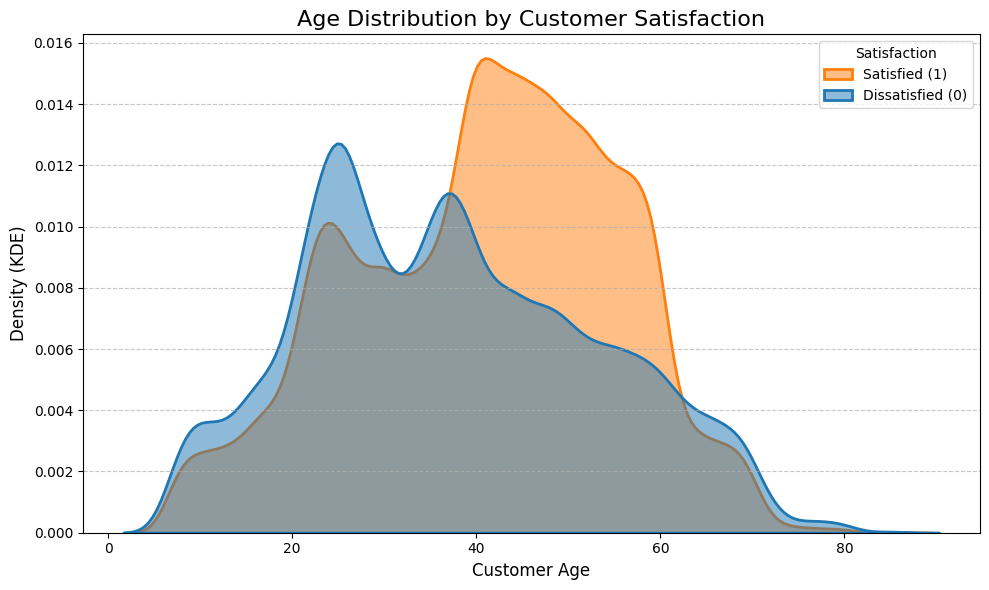

In [18]:
plt.figure(figsize=(10, 6))

# Kernel Density Estimate (KDE) plot of 'Age' by customer satisfaction
sns.kdeplot(
    data=df,
    x='Age',
    hue='satisfaction',
    fill=True,
    alpha=0.5,
    linewidth=2
)

# Add clear titles and axis labels
plt.title('Age Distribution by Customer Satisfaction', fontsize=16)
plt.xlabel('Customer Age', fontsize=12)
plt.ylabel('Density (KDE)', fontsize=12)

# Add a clear legend
plt.legend(title='Satisfaction', labels=['Satisfied (1)', 'Dissatisfied (0)'])

# Add subtle horizontal grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The ridgeline plot illustrates customer satisfaction levels as a function of age. The results indicate that a larger proportion of **younger** customers *(aged 20–40)* are dissatisfied with the airline, whereas satisfaction is more prevalent among **middle-aged** customers *(aged 40–60)*. Overall, older customers tend to exhibit higher satisfaction levels across all evaluated features compared to younger travelers.

This pattern suggests that younger passengers may be more critical and hold higher expectations regarding airline services than middle-aged or older customers. Notably, the number of travelers in the 20–40 and 40–60 age groups is approximately comparable, reinforcing the robustness of this observation.

*Remark:* Interestingly, a notable contrast emerges regarding in-flight entertainment. Among passengers aged 20–40, dissatisfaction is primarily driven by this feature, whereas those aged 40–60 report high levels of satisfaction with it. In other words, the same feature contributes to both satisfaction and dissatisfaction across different age groups. This suggests that airline offerings such as movies, music, and other in-flight entertainment options tend to appeal more strongly to older passengers.

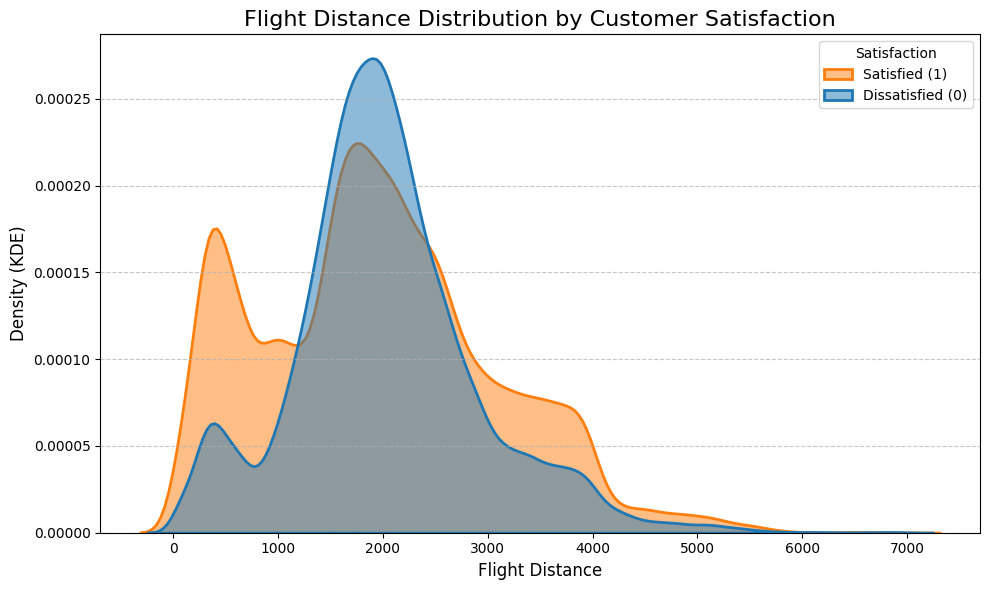

In [19]:
plt.figure(figsize=(10, 6))

# Kernel Density Estimate (KDE) plot of 'FlightDistance' by customer satisfaction
sns.kdeplot(
    data=df,
    x='FlightDistance',
    hue='satisfaction',
    fill=True,
    alpha=0.5,
    linewidth=2
)

# Add clear titles and axis labels
plt.title('Flight Distance Distribution by Customer Satisfaction', fontsize=16)
plt.xlabel('Flight Distance', fontsize=12)
plt.ylabel('Density (KDE)', fontsize=12)

# Add a clear legend
plt.legend(title='Satisfaction', labels=['Satisfied (1)', 'Dissatisfied (0)'])

# Add subtle horizontal grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

We further examine a plot illustrating customer satisfaction as a function of the distance traveled by passengers. While one might expect satisfaction to decrease on longer flights due to factors such as travel fatigue or boredom, the observed pattern does not support this assumption.

The visualization shows that passengers traveling between 2,000 and 3,000 miles are **nearly equally** likely to report satisfaction or dissatisfaction, indicating that flight distance alone does not appear to be a determining factor of customer satisfaction.

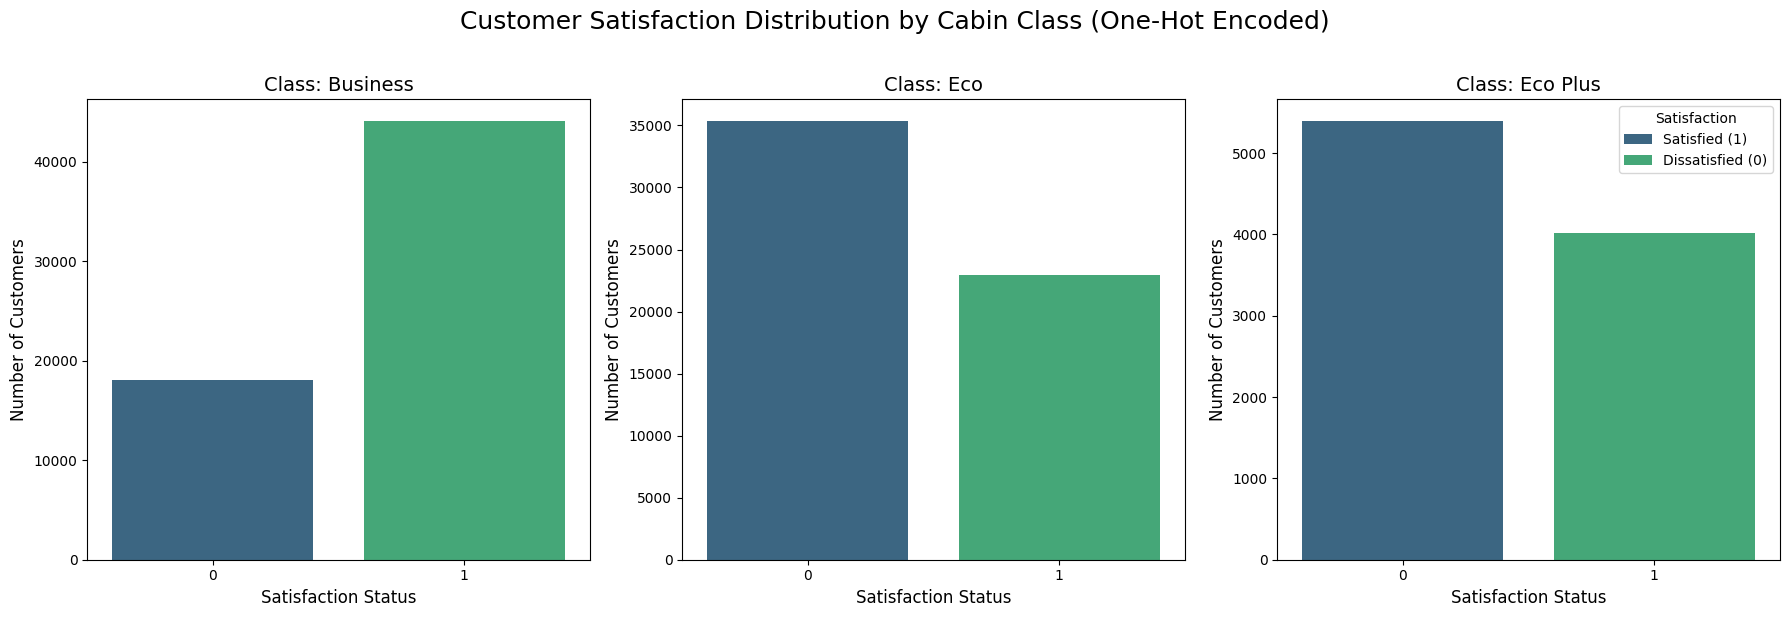

In [20]:
# List of one-hot encoded columns for 'Class'
ohe_class_columns = ['Class_Business', 'Class_Eco', 'Class_Eco Plus']

# Create figure and subplots
fig, axes = plt.subplots(1, len(ohe_class_columns), figsize=(18, 6))
fig.suptitle('Customer Satisfaction Distribution by Cabin Class (One-Hot Encoded)', fontsize=18, y=1.02)

# Loop through each one-hot encoded class column
for i, class_col in enumerate(ohe_class_columns):
    ax = axes[i]

    # Filter DataFrame for passengers of this class (value = 1)
    df_filtered = df[df[class_col] == 1].copy()

    if df_filtered.empty:
        ax.set_title(f"No data for {class_col.replace('Class_', '')}")
        continue

    # Plot countplot for satisfaction
    sns.countplot(
        x='satisfaction',
        data=df_filtered,
        palette='viridis',
        hue='satisfaction',
        legend=False,
        ax=ax
    )

    # Get readable class name
    class_display_name = class_col.replace('Class_', '')

    # Titles and labels
    ax.set_title(f'Class: {class_display_name}', fontsize=14)
    ax.set_xlabel('Satisfaction Status', fontsize=12)
    ax.set_ylabel('Number of Customers', fontsize=12)

# Fix x-ticks and replace with readable labels
plt.legend(title='Satisfaction', labels=['Satisfied (1)', 'Dissatisfied (0)'])
plt.tight_layout()
plt.show()

The visualization reveals a clear disparity in satisfaction levels across travel classes, with **business-class** passengers exhibiting higher satisfaction rates compared to those traveling in **economy class**.

*Remark:* Interestingly, passengers in both classes assigned high ratings to seat comfort, food and beverages, and legroom. However, further analysis revealed substantial differences in the average ratings for in-flight entertainment, online booking, and online boarding services between business and economy travelers. Business-class passengers consistently rated these features significantly higher than their economy-class counterparts.

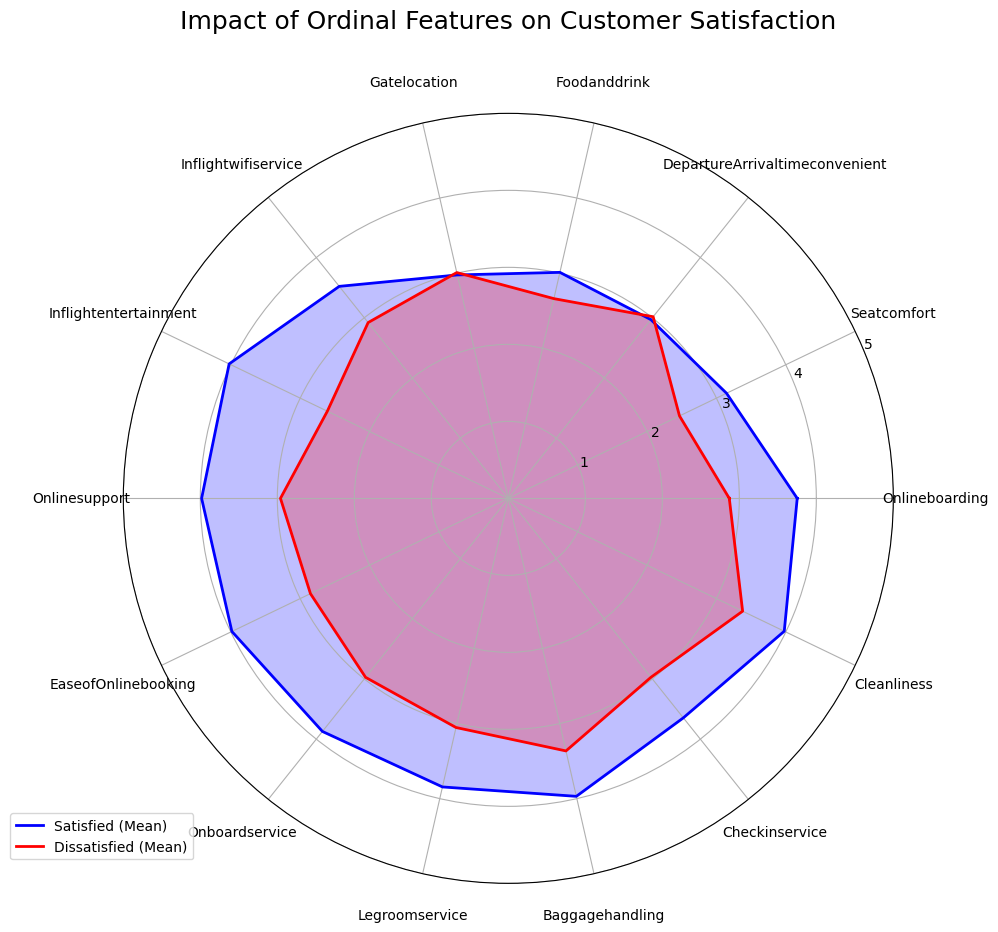

In [21]:
# Compute the mean of each ordinal feature by satisfaction level (0 = Dissatisfied/Neutral, 1 = Satisfied)
# NaN values are automatically skipped by default (skipna=True).
data = df.groupby('satisfaction', observed=False)[ordinal_features].mean().reset_index()

# Extract mean scores for each group
satisfied_scores = data[data['satisfaction'] == 1].drop(columns=['satisfaction']).values[0]
dissatisfied_scores = data[data['satisfaction'] == 0].drop(columns=['satisfaction']).values[0]

# Configure Radar Chart
labels = np.array(ordinal_features)
num_vars = len(labels)

# Create an array of angles for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Close the radar by repeating the first value at the end
satisfied_scores = np.concatenate((satisfied_scores, [satisfied_scores[0]]))
dissatisfied_scores = np.concatenate((dissatisfied_scores, [dissatisfied_scores[0]]))
angles = np.concatenate((angles, [angles[0]]))

# Plot Radar Chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Plot satisfied customers (blue)
ax.plot(angles, satisfied_scores, color='blue', linewidth=2, linestyle='solid', label='Satisfied (Mean)')
ax.fill(angles, satisfied_scores, color='blue', alpha=0.25)

# Plot dissatisfied customers (red)
ax.plot(angles, dissatisfied_scores, color='red', linewidth=2, linestyle='solid', label='Dissatisfied (Mean)')
ax.fill(angles, dissatisfied_scores, color='red', alpha=0.25)

# Configure axes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)

# Set rating scale (0 to 5, adjust if necessary)
ax.set_yticks(np.arange(1, 6, 1))
ax.set_ylim(0, 5)

# Add title and legend
plt.title('Impact of Ordinal Features on Customer Satisfaction', size=18, y=1.1)
ax.tick_params(axis='x', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()

The analysis reveals a pronounced gap in average ratings between satisfied and dissatisfied customers, particularly for in-flight entertainment, online support, online booking convenience, and on-board services.

In [22]:
# Exclude IDs, one-hot encoded, and binary columns that are not true numeric measurements
EXCLUDED_COLS = [
    'satisfaction', 'Class_Business', 'Class_Eco', 'Class_Eco Plus',
    # Add any other non-numeric or binary columns here
]

# Identify numeric features to test
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_features = [col for col in numerical_cols if col not in EXCLUDED_COLS]

# Separate data by satisfaction status
df_satisfied = df[df['satisfaction'] == 1]
df_dissatisfied = df[df['satisfaction'] == 0]

# Perform t-tests
ttest_results = []

print("--- T-Test Results (Satisfied vs. Dissatisfied Customers) ---")
print(f"{'Feature':<30} | {'Mean Sat.':<10} | {'Mean Dissat.':<12} | {'t-Stat':<8} | {'p-value':<10} | Significance")
print("-" * 90)

for feature in numerical_features:
    group1 = df_satisfied[feature].dropna()
    group0 = df_dissatisfied[feature].dropna()

    # Skip if not enough data
    if len(group1) < 2 or len(group0) < 2:
        print(f"{feature:<30} | Not enough data for t-test.")
        continue

    # Levene's test for equality of variances
    try:
        levene_test = stats.levene(group1, group0)
        equal_var = levene_test.pvalue >= 0.05
    except ValueError:
        equal_var = False

    # Perform independent t-test
    t_stat, p_value = stats.ttest_ind(group1, group0, equal_var=equal_var)

    # Determine significance indicator
    if p_value < 0.001:
        sig = '***'
    elif p_value < 0.01:
        sig = '**'
    elif p_value < 0.05:
        sig = '*'
    else:
        sig = ''

    # Store results
    ttest_results.append({
        'Feature': feature,
        'Mean_Satisfied': group1.mean(),
        'Mean_Dissatisfied': group0.mean(),
        'T_Statistic': t_stat,
        'P_Value': p_value,
        'Significant': p_value < 0.05
    })

    # Print nicely
    print(f"{feature:<30} | {group1.mean():<10.2f} | {group0.mean():<12.2f} | {t_stat:<8.2f} | {p_value:<10.2e} | {sig}")

--- T-Test Results (Satisfied vs. Dissatisfied Customers) ---
Feature                        | Mean Sat.  | Mean Dissat. | t-Stat   | p-value    | Significance
------------------------------------------------------------------------------------------
CustomerType                   | 0.08       | 0.31         | -105.32  | 0.00e+00   | ***
Age                            | 41.05      | 37.47        | 42.38    | 0.00e+00   | ***
TypeofTravel                   | 0.26       | 0.36         | -39.27   | 0.00e+00   | ***
FlightDistance                 | 1944.77    | 2025.71      | -14.46   | 2.21e-47   | ***
Seatcomfort                    | 3.15       | 2.47         | 93.82    | 0.00e+00   | ***
DepartureArrivaltimeconvenient | 2.97       | 3.02         | -5.60    | 2.15e-08   | ***
Foodanddrink                   | 3.01       | 2.66         | 44.78    | 0.00e+00   | ***
Gatelocation                   | 2.98       | 3.01         | -4.40    | 1.08e-05   | ***
Inflightwifiservice            | 3.52

To assess whether the differences in mean ratings between satisfied and dissatisfied customers are **statistically significant**, we conducted independent t-tests. The results, summarized in the table below, show that all t-tests yielded highly significant p-values, indicating that the mean differences across all evaluated variables between the two customer groups are indeed significant.

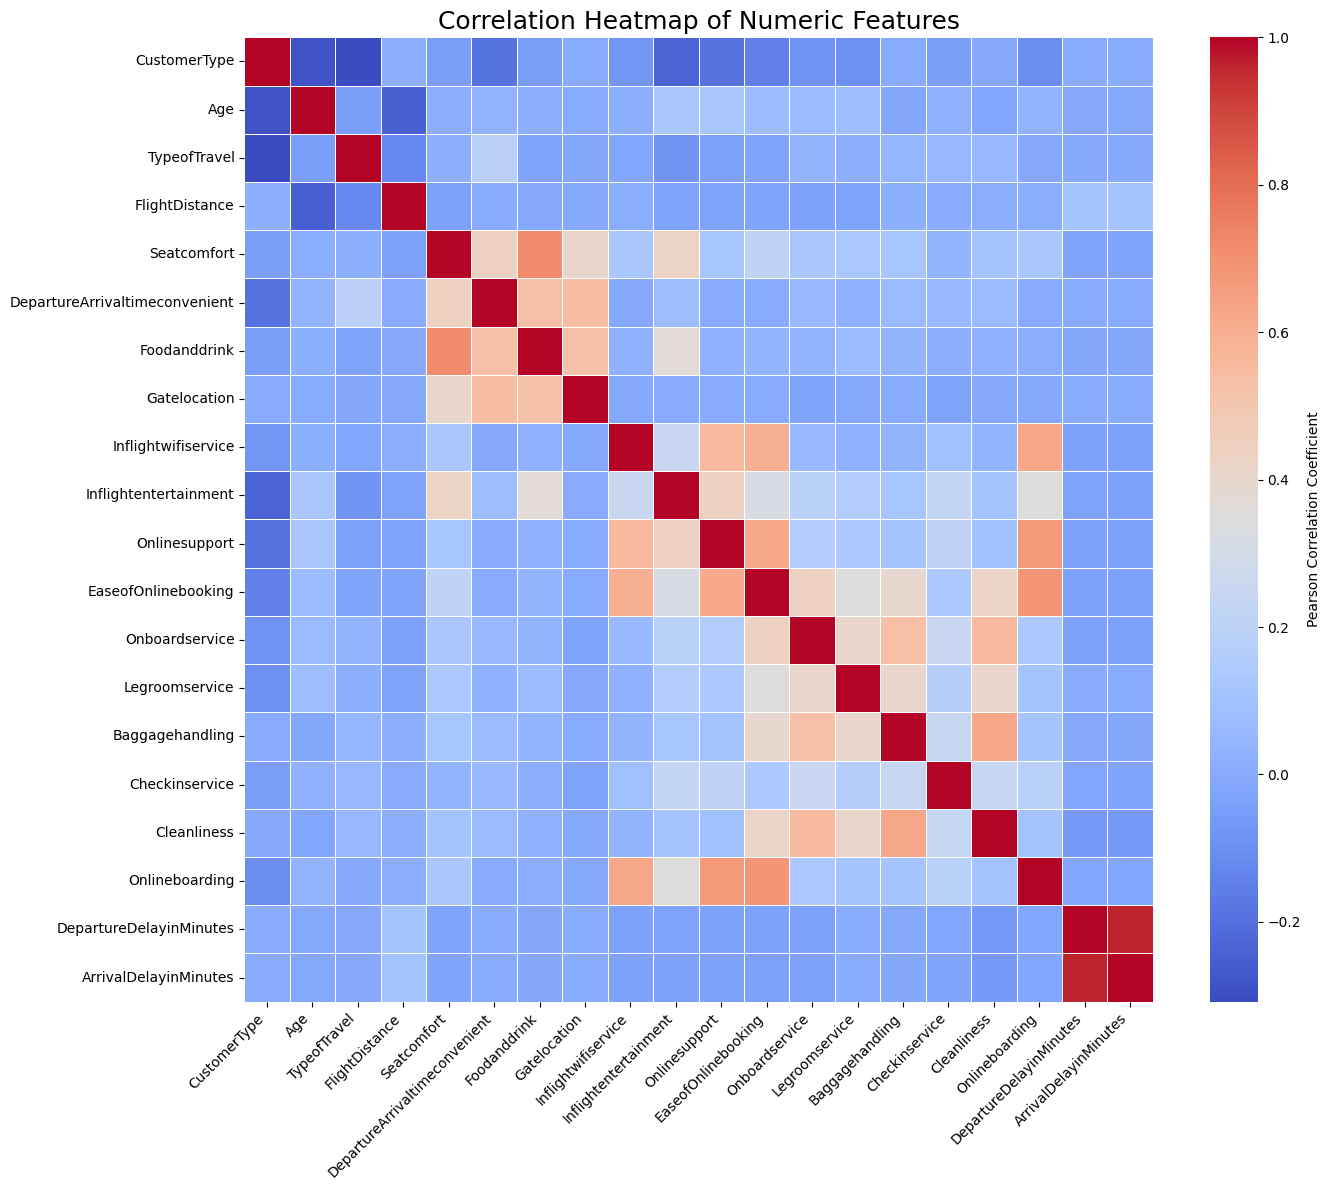

In [23]:
# Select numeric columns for correlation
numerical_df = df.select_dtypes(include=np.number).drop(columns=EXCLUDED_COLS, errors='ignore')

# Compute the Pearson correlation matrix
correlation_matrix = numerical_df.corr()

# Sort columns to emphasize relationship with 'satisfaction'
if 'satisfaction' in correlation_matrix.columns:
    corr_sorted = correlation_matrix.sort_values(by='satisfaction', ascending=False)
    correlation_matrix = corr_sorted[corr_sorted.index]  # Sort columns according to sorted rows

plt.figure(figsize=(14, 12))

# Create Seaborn heatmap
sns.heatmap(
    correlation_matrix,
    annot=False,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    cbar_kws={'label': 'Pearson Correlation Coefficient'}
)

# Improve readability
plt.title('Correlation Heatmap of Numeric Features', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [24]:
# Get the upper triangle of the correlation matrix to avoid duplicate pairs
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
corr_threshold = 0.7

# Extract strong correlations above the threshold
strong_corr = upper.stack()
strong_corr = strong_corr[strong_corr.abs() > corr_threshold]
strong_corr = strong_corr.sort_values(ascending=False)

# Display the strong correlations
print(f"Strong correlations (|corr| > {corr_threshold}):")
if not strong_corr.empty:
    print(strong_corr)
else:
    print("No feature pairs exceed the threshold.")

Strong correlations (|corr| > 0.7):
DepartureDelayinMinutes  ArrivalDelayinMinutes    0.959382
Seatcomfort              Foodanddrink             0.715997
dtype: float64


A correlation matrix was plotted to assess potential multicollinearity among the independent variables. The matrix reveals that `ArrivalDelayinMinutes` and `DepartureDelayinMinutes`are highly correlated, suggesting that these two variables may convey similar information.

### Part 2 - Predictive Modeling of Customer Satisfaction

#### Import

In [25]:
import time
from tqdm.auto import tqdm
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, f1_score, auc
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

#### Data Preparation

We are now preparing the data for training the prediction models. This step involves separating the target variable from the explanatory variables, normalising the data *(particularly for logistic regression)* and performing stratified separation of the training and test sets.

In [26]:
# Define features and target
X = df.drop(columns=['satisfaction', 'DepartureDelayinMinutes'])
y = df['satisfaction']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets (stratified by target)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Print dataset info
print(f"Training samples: {X_train.shape[0]} | Test samples: {X_test.shape[0]} | Number of features: {X.shape[1]}")

Training samples: 103904 | Test samples: 25976 | Number of features: 22


#### Model Training

For our prediction task, we chose to evaluate four distinct models: `Logistic Regression`, `Decision Tree`, `Random Forest`, and `XGBoost` *(gradient boosting approach)*. We also defined a parameter dictionary in order to perform an exhaustive grid search for hyperparameter optimisation.

In [27]:
# Define models and their respective parameter grids
models_and_params = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'classifier__C': [0.1, 1.0, 10.0],
            'classifier__solver': ['liblinear', 'lbfgs']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'classifier__max_depth': [10, 15, 20],
            'classifier__min_samples_leaf': [5, 10]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [15, 25],
            'classifier__min_samples_split': [2, 5]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.1, 0.2],
            'classifier__max_depth': [3, 5, 7]
        }
    }
}

In [28]:
# Initialize storage for results and trained models
results: list[dict] = []
trained_estimators: dict[str, BaseEstimator] = {}

# Track the best performing model
best_accuracy_so_far: float = 0.0
overall_best_estimator: BaseEstimator | None = None
best_model_name: str | None = None

# Cross-validation configuration
cv_folds: int = 3

In [29]:
class TQDMGridSearchCV(GridSearchCV):
    """
    GridSearchCV with a tqdm progress bar that updates at each CV fit
    and displays ETA.
    """

    def fit(self, X, y=None, **fit_params):
        # Total number of fits = number of parameter combinations × CV folds
        n_candidates = len(list(ParameterGrid(self.param_grid)))
        total_fits = n_candidates * self.cv

        # tqdm progress bar (per model)
        self._tqdm_bar = tqdm(
            total=total_fits,
            desc="GridSearchCV",
            unit="fit",
            leave=True
        )

        return super().fit(X, y, **fit_params)

    def _run_search(self, evaluate_candidates):
        """
        Wrap the evaluation of candidates to update tqdm after each fit
        """

        def wrapped_evaluate_candidates(candidate_params):
            # Run the original evaluation
            out = evaluate_candidates(candidate_params)

            # Update tqdm: number of fits just completed
            self._tqdm_bar.update(len(candidate_params) * self.cv)

            return out

        return super()._run_search(wrapped_evaluate_candidates)

    def _finalize(self):
        # Close tqdm bar cleanly
        if hasattr(self, "_tqdm_bar"):
            self._tqdm_bar.close()

In [30]:
# Loop through all models and perform GridSearchCV
for name, config in models_and_params.items():

    print(f"\nTraining model: {name}")
    start_time = time.time()

    # Extract model and hyperparameter grid
    model = config['model']
    param_grid = config['params']

    # Build a pipeline
    pipeline = Pipeline([
        ('classifier', model)
    ])

    # Configure GridSearchCV
    grid_search = TQDMGridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv_folds,
        scoring='accuracy',
        n_jobs=1,
        verbose=2
    )


    grid_search.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    # Best estimator from grid search
    best_estimator = grid_search.best_estimator_
    y_pred = best_estimator.predict(X_test)

    # Evaluation metrics
    test_accuracy = accuracy_score(y_test, y_pred)
    test_roc_auc = roc_auc_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)

    print(f"Time: {elapsed_time:.2f}s")
    print(f"Best params: {grid_search.best_params_}")
    print(
        f"Accuracy: {test_accuracy:.4f} | "
        f"ROC-AUC: {test_roc_auc:.4f} | "
        f"F1: {test_f1:.4f}"
    )

    # Store results
    results.append({
        'Model': name,
        'Test_Accuracy': test_accuracy,
        'Test_ROC-AUC': test_roc_auc,
        'Test_F1': test_f1,
        'Training_Time_(s)': elapsed_time,
        'Best_Params': grid_search.best_params_
    })

    trained_estimators[name] = best_estimator

    # Track the overall best model
    if test_accuracy > best_accuracy_so_far:
        best_accuracy_so_far = test_accuracy
        best_model_name = name
        overall_best_estimator = best_estimator



Training model: Logistic Regression


GridSearchCV:   0%|          | 0/18 [00:00<?, ?fit/s]

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ....classifier__C=0.1, classifier__solver=liblinear; total time=   0.1s
[CV] END ....classifier__C=0.1, classifier__solver=liblinear; total time=   0.1s
[CV] END ....classifier__C=0.1, classifier__solver=liblinear; total time=   0.1s
[CV] END ........classifier__C=0.1, classifier__solver=lbfgs; total time=   0.0s
[CV] END ........classifier__C=0.1, classifier__solver=lbfgs; total time=   0.0s
[CV] END ........classifier__C=0.1, classifier__solver=lbfgs; total time=   0.0s
[CV] END ....classifier__C=1.0, classifier__solver=liblinear; total time=   0.1s
[CV] END ....classifier__C=1.0, classifier__solver=liblinear; total time=   0.1s
[CV] END ....classifier__C=1.0, classifier__solver=liblinear; total time=   0.1s
[CV] END ........classifier__C=1.0, classifier__solver=lbfgs; total time=   0.0s
[CV] END ........classifier__C=1.0, classifier__solver=lbfgs; total time=   0.0s
[CV] END ........classifier__C=1.0, classifier__s

GridSearchCV:   0%|          | 0/18 [00:00<?, ?fit/s]

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END classifier__max_depth=10, classifier__min_samples_leaf=5; total time=   0.3s
[CV] END classifier__max_depth=10, classifier__min_samples_leaf=5; total time=   0.2s
[CV] END classifier__max_depth=10, classifier__min_samples_leaf=5; total time=   0.2s
[CV] END classifier__max_depth=10, classifier__min_samples_leaf=10; total time=   0.2s
[CV] END classifier__max_depth=10, classifier__min_samples_leaf=10; total time=   0.2s
[CV] END classifier__max_depth=10, classifier__min_samples_leaf=10; total time=   0.2s
[CV] END classifier__max_depth=15, classifier__min_samples_leaf=5; total time=   0.3s
[CV] END classifier__max_depth=15, classifier__min_samples_leaf=5; total time=   0.3s
[CV] END classifier__max_depth=15, classifier__min_samples_leaf=5; total time=   0.3s
[CV] END classifier__max_depth=15, classifier__min_samples_leaf=10; total time=   0.3s
[CV] END classifier__max_depth=15, classifier__min_samples_leaf=10; total ti

GridSearchCV:   0%|          | 0/36 [00:00<?, ?fit/s]

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END classifier__max_depth=15, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__max_depth=15, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__max_depth=15, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.1s
[CV] END classifier__max_depth=15, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   2.2s
[CV] END classifier__max_depth=15, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   2.3s
[CV] END classifier__max_depth=15, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   2.3s
[CV] END classifier__max_depth=15, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   3.5s
[CV] END classifier__max_depth=15, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   3.4s
[CV

GridSearchCV:   0%|          | 0/36 [00:00<?, ?fit/s]

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200; total time=   0.3s
[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200; total time=   0.4s
[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200; total time=   0.3s
[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.1, classifier__max_depth=5, classifier__n_estimators=100; total time=   0.3s
[CV] END classifier__learni

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


[CV] END classifier__learning_rate=0.1, classifier__max_depth=7, classifier__n_estimators=200; total time=   0.7s
[CV] END classifier__learning_rate=0.1, classifier__max_depth=7, classifier__n_estimators=200; total time=   0.7s
[CV] END classifier__learning_rate=0.2, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.2, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.2, classifier__max_depth=3, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__learning_rate=0.2, classifier__max_depth=3, classifier__n_estimators=200; total time=   0.2s
[CV] END classifier__learning_rate=0.2, classifier__max_depth=3, classifier__n_estimators=200; total time=   0.3s
[CV] END classifier__learning_rate=0.2, classifier__max_depth=3, classifier__n_estimators=200; total time=   0.2s
[CV] END classifier__learning_rate=0.2, classifier__max_depth=5, classifier__n_estimator

#### Model Evaluation

Based on the metrics calculated during training *(including accuracy, AUC and F1 score)*, we now evaluate the performance of the different models in order to identify the one offering the best results.

In [31]:
# Convert results to DataFrame and add percentage column
results_df = pd.DataFrame(results).sort_values(by='Test_Accuracy', ascending=False).reset_index(drop=True)
results_df['Test_Accuracy_Percent'] = (results_df['Test_Accuracy'] * 100).round(2)

# Print summary table
print(f"\nOverall Best Model: {best_model_name}\n")
print("Optimized Models Comparison Table:")
print(results_df[['Model', 'Test_Accuracy_Percent', 'Test_F1', 'Training_Time_(s)', 'Best_Params']].to_string(index=False))


Overall Best Model: XGBoost

Optimized Models Comparison Table:
              Model  Test_Accuracy_Percent  Test_F1  Training_Time_(s)                                                                                        Best_Params
            XGBoost                  95.70 0.960349          17.104396    {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 200}
      Random Forest                  95.64 0.959781         104.275518 {'classifier__max_depth': 25, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
      Decision Tree                  94.28 0.947185           7.120549                                   {'classifier__max_depth': 15, 'classifier__min_samples_leaf': 5}
Logistic Regression                  82.97 0.844321           2.537559                                              {'classifier__C': 0.1, 'classifier__solver': 'lbfgs'}


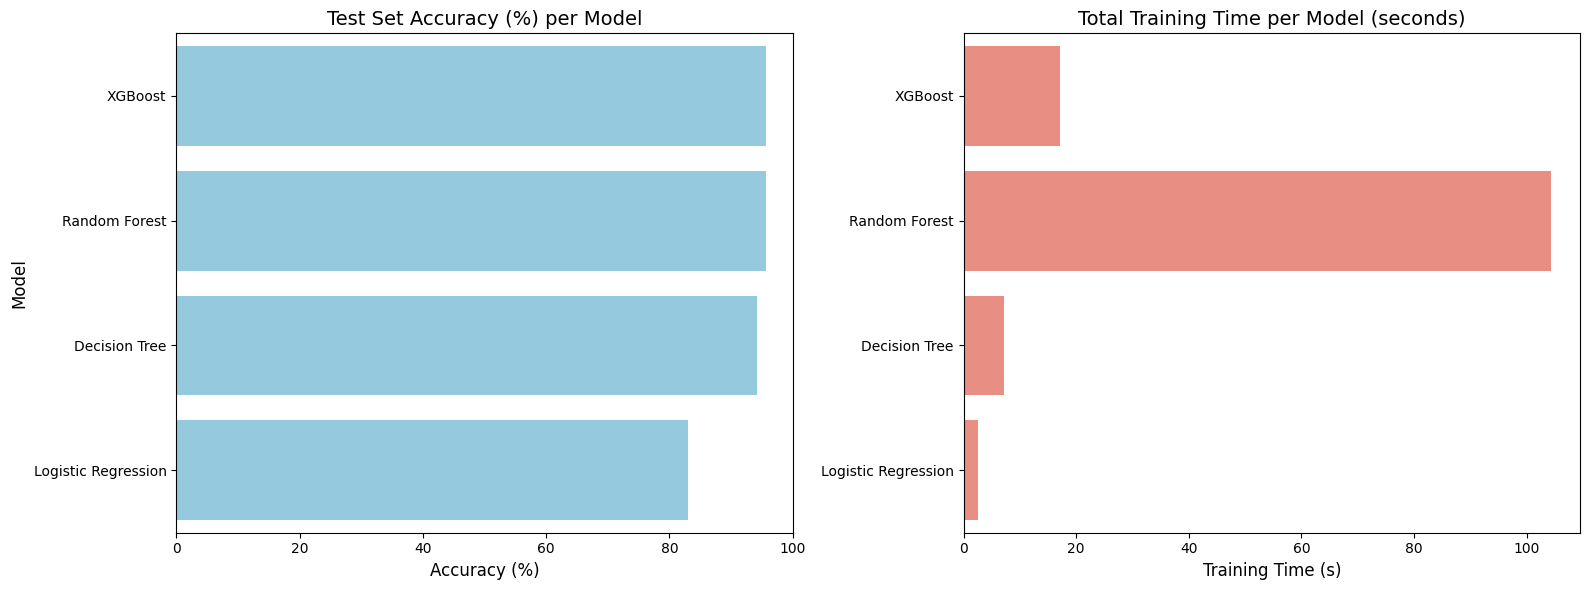

In [32]:
# Plot Accuracy and Training Time
plt.figure(figsize=(16, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
sns.barplot(
    x='Test_Accuracy_Percent',
    y='Model',
    data=results_df,
    color='skyblue',
    dodge=False
)
plt.title('Test Set Accuracy (%) per Model', fontsize=14)
plt.xlabel('Accuracy (%)', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(min(results_df['Test_Accuracy_Percent'].min() - 1, 0), 100)

# Training time plot
plt.subplot(1, 2, 2)
sns.barplot(
    x='Training_Time_(s)',
    y='Model',
    data=results_df,
    color='salmon',
    dodge=False
)
plt.title('Total Training Time per Model (seconds)', fontsize=14)
plt.xlabel('Training Time (s)', fontsize=12)
plt.ylabel('')

plt.tight_layout()
plt.show()

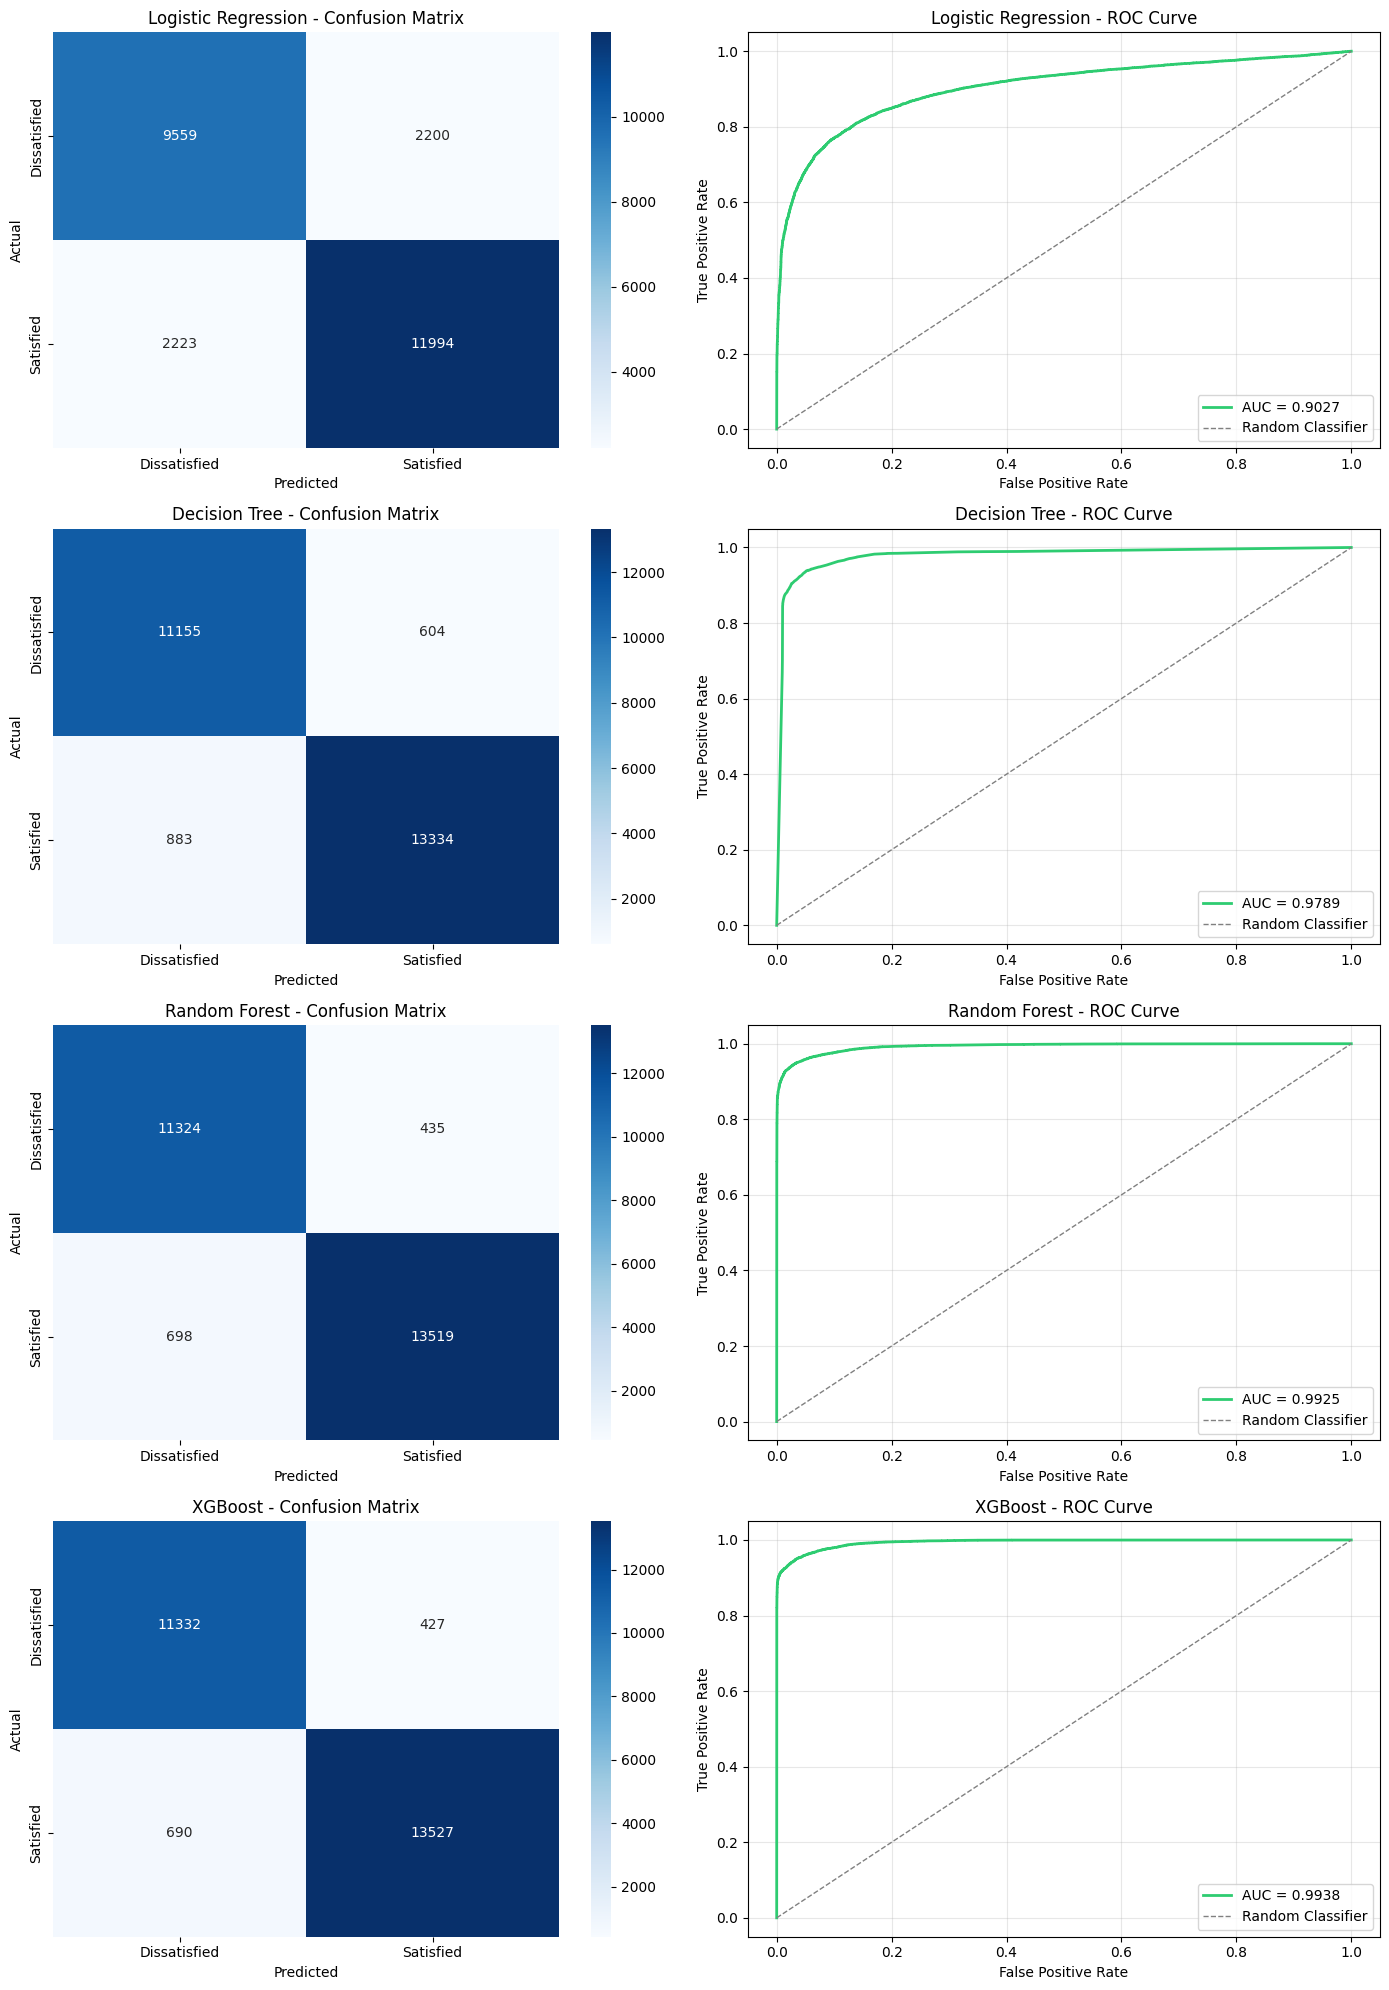

In [33]:
# List of trained model names
model_names = list(trained_estimators.keys())
n_models = len(model_names)

# Create a grid of subplots (2 columns: CM + ROC for each model)
fig, axes = plt.subplots(n_models, 2, figsize=(14, 5 * n_models))

# Ensure axes is always 2D for consistent indexing
if n_models == 1:
    axes = np.array([axes])

for i, name in enumerate(model_names):
    estimator = trained_estimators[name]

    # Predictions
    y_pred = estimator.predict(X_test)

    # Probabilities for ROC (fallback to decision_function or predictions)
    if hasattr(estimator.named_steps['classifier'], "predict_proba"):
        y_pred_proba = estimator.predict_proba(X_test)[:, 1]
    elif hasattr(estimator.named_steps['classifier'], "decision_function"):
        y_pred_proba = estimator.named_steps['classifier'].decision_function(X_test)
    else:
        y_pred_proba = y_pred

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=axes[i, 0],
        xticklabels=['Dissatisfied', 'Satisfied'],
        yticklabels=['Dissatisfied', 'Satisfied']
    )
    axes[i, 0].set_title(f'{name} - Confusion Matrix', fontsize=12)
    axes[i, 0].set_xlabel('Predicted', fontsize=10)
    axes[i, 0].set_ylabel('Actual', fontsize=10)

    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    axes[i, 1].plot(fpr, tpr, color='#2ecc71', linewidth=2, label=f'AUC = {roc_auc:.4f}')
    axes[i, 1].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1, label='Random Classifier')
    axes[i, 1].set_title(f'{name} - ROC Curve', fontsize=12)
    axes[i, 1].set_xlabel('False Positive Rate', fontsize=10)
    axes[i, 1].set_ylabel('True Positive Rate', fontsize=10)
    axes[i, 1].legend(loc='lower right', fontsize=10)
    axes[i, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In terms of predictive performance, two models stand out with extremely similar results: Random Forest and XGBoost. These two approaches perform almost identically across all metrics evaluated, including accuracy, F1 score and ROC curve AUC. So much so that the differences observed between the two models are not statistically significant enough to allow for a meaningful distinction.

Furthermore, analysis of the confusion matrices reveals very similar results in terms of false positives and false negatives. On the other hand, when considering computational aspects *(in particular execution time and hyperparameter search time)*, the XGBoost model proves to be significantly more efficient than Random Forest.

This last factor is a decisive criterion in an application context. We therefore conclude that the **XGBoost** model represents the best compromise for the business application of customer satisfaction prediction, offering both excellent predictive performance and reduced computational cost thanks to faster training.

#### Model Interpretation

The final phase of the customer satisfaction prediction process *(probably the most decisive in operational terms)* involves interpreting the models and analysing the underlying mechanisms that explain the predictions made.

In [34]:
# Extract Logistic Regression Classifier
log_reg = trained_estimators['Logistic Regression'].named_steps['classifier']

# Extract feature names and coefficients
feature_names = X.columns if hasattr(X, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]
coef_values = log_reg.coef_[0]

# Create DataFrame of features and coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef_values
})

# Sort features by absolute coefficient for importance
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print(top_features[['Feature', 'Coefficient']].to_string(index=False))

                       Feature  Coefficient
         Inflightentertainment     0.963417
                  CustomerType    -0.726954
                Onboardservice     0.401059
                   Seatcomfort     0.389259
                Checkinservice     0.356777
                  TypeofTravel    -0.356218
DepartureArrivaltimeconvenient    -0.330219
           EaseofOnlinebooking     0.318042
                Legroomservice     0.309015
                  Foodanddrink    -0.286236
                Class_Business     0.201892
                Onlineboarding     0.191741
                FlightDistance    -0.186201
         ArrivalDelayinMinutes    -0.185743
                  Gatelocation     0.154667
                     Class_Eco    -0.153555
                 Onlinesupport     0.149020
                           Age    -0.134312
           Inflightwifiservice    -0.117711
               Baggagehandling     0.102775
                Class_Eco Plus    -0.094416
                   Cleanliness  

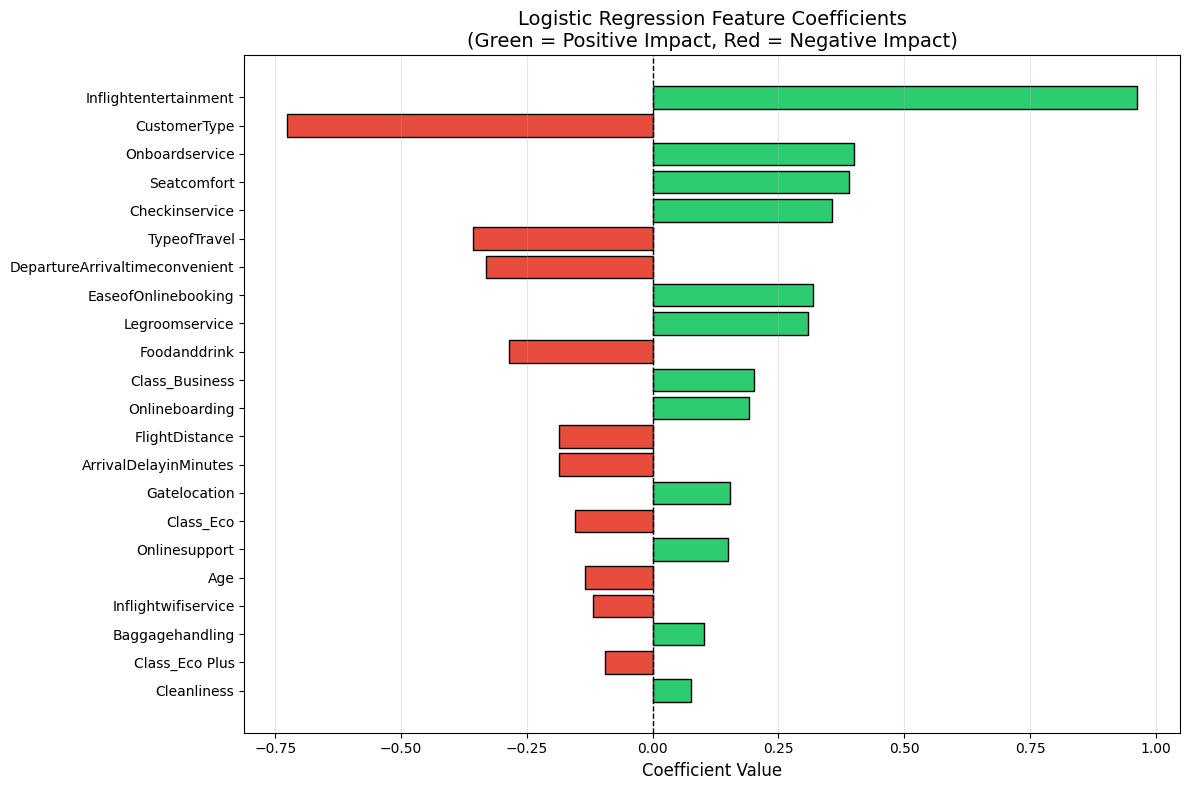

In [35]:
# Assign colors based on sign of coefficient
colors = ['#2ecc71' if coef > 0 else '#e74c3c' for coef in top_features['Coefficient']]

# Plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, edgecolor='black')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Logistic Regression Feature Coefficients\n(Green = Positive Impact, Red = Negative Impact)', fontsize=14)

# Add vertical line at zero
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

# Grid for readability
plt.grid(axis='x', alpha=0.3)

# Invert y-axis so the most important feature is on top
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

Logistic regression coefficients clearly indicate which factors most strongly influence the likelihood of customer satisfaction and the direction of their impact.

**In-flight entertainment** is the most influential positive driver of satisfaction *(coefficient ≈ 0.96)*, confirming that improving the quality, variety and accessibility of content can significantly increase the probability of customer satisfaction. From a business perspective, this is a highly impactful lever with relatively scalable investment requirements *(e.g. content licensing, UX improvements, personalisation)*.

Several variables related to **service quality** and **comfort** also show a strong positive effect, including on-board service, seat comfort, check-in service, legroom and the ease with which customers can book online. These results highlight that satisfaction is strongly influenced by the overall experience, encompassing physical comfort during the flight and service interactions prior to boarding. Therefore, targeted investments in staff training, cabin ergonomics, and digital usability are likely to measurably increase satisfaction.

Conversely, some variables exhibit negative coefficients, indicating potential sources of dissatisfaction or higher expectations. Notably, `CustomerType` and `Type of Travel` have strong negative effects, suggesting that certain customer segments *(such as frequent or business travellers)* may have higher expectations and be more difficult to satisfy. This implies the need for differentiated service strategies and more personalised offerings for high-value or frequent customers.

Although their magnitudes are smaller than those of service-related features, **operational constraints** such as arrival delays, flight distance, and departure/arrival time convenience also negatively impact satisfaction. While these factors are more difficult and costly to control, reducing dissatisfaction could be achieved by mitigating their effects through better communication, compensation policies, or proactive customer support.

**Class-related variables** further reinforce the effects of segmentation: the business class coefficient is positive, whereas the coefficients for the economy and eco-plus classes are negative. These differences in perceived value and expectations suggest that improving the perceived value of the economy class *(through low-cost enhancements or clearer expectation management)* could be a cost-effective strategy.

**Key business takeaway:** Customer satisfaction is driven far more by perceived service quality and experience than by unchangeable operational factors. Therefore, airlines can achieve the highest return on investment by prioritising improvements in areas such as in-flight entertainment, service quality, comfort and digital touchpoints, while adopting differentiated strategies for demanding customer segments and economy-class travellers.

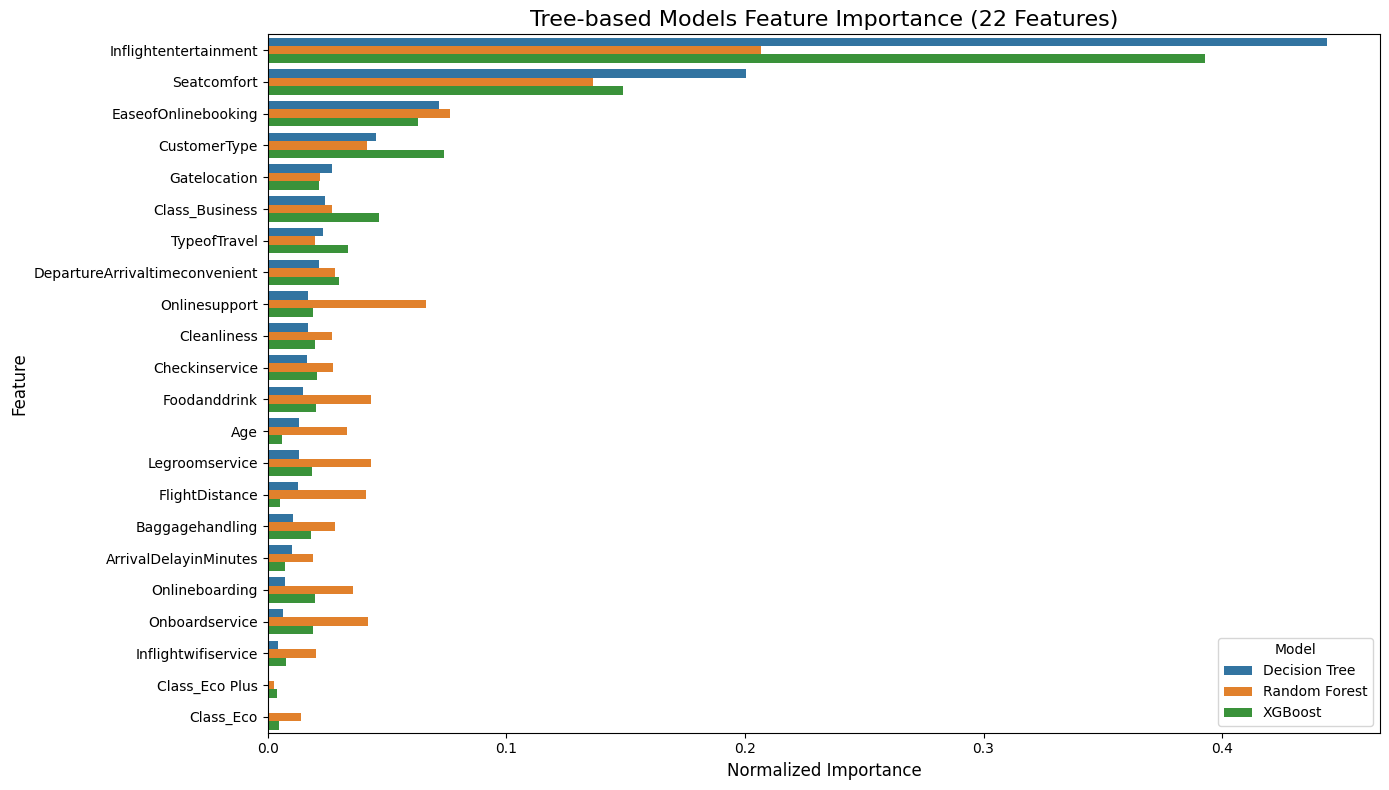

In [36]:
importance_data = []

# Only keep tree-based models
feature_models = ['Decision Tree', 'Random Forest', 'XGBoost']
feature_names_out = X.columns
nb_features = len(feature_names_out)

# Extract feature importances for each model
for name in feature_models:
    estimator = trained_estimators.get(name)
    if estimator is None:
        continue

    classifier = estimator.named_steps['classifier']

    # Check if the model provides feature_importances_
    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_
    else:
        continue

    # Match feature names to importances
    valid_feature_names = feature_names_out[:len(importances)]
    feature_importance_series = pd.Series(importances, index=valid_feature_names)

    # Normalize importances (sum = 1)
    feature_importance_normalized = feature_importance_series / feature_importance_series.sum()

    # Select top features
    top_features = feature_importance_normalized.sort_values(ascending=False).head(nb_features)

    # Append to data list
    for feature, importance in top_features.items():
        importance_data.append({
            'Model': name,
            'Feature': feature,
            'Importance': importance
        })

# Convert to DataFrame
importance_df = pd.DataFrame(importance_data)

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    hue='Model',
    data=importance_df,
    palette='tab10'
)

plt.title(f'Tree-based Models Feature Importance ({nb_features} Features)', fontsize=16)
plt.xlabel("Normalized Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [37]:
# Pivot the DataFrame to have features as rows and models as columns
pivot_table = importance_df.pivot_table(
    index='Feature',
    columns='Model',
    values='Importance'
).fillna(0)

# Sort features by their importances across models (descending order)
# This ensures the most important features appear at the top
sorted_table = pivot_table.sort_values(by=feature_models, ascending=False)

# Display the top N features with 4 decimal places
print(sorted_table.head(nb_features).to_string(float_format="{:.4f}".format))

Model                           Decision Tree  Random Forest  XGBoost
Feature                                                              
Inflightentertainment                  0.4440         0.2069   0.3930
Seatcomfort                            0.2004         0.1361   0.1489
EaseofOnlinebooking                    0.0716         0.0763   0.0632
CustomerType                           0.0455         0.0416   0.0740
Gatelocation                           0.0270         0.0218   0.0214
Class_Business                         0.0238         0.0269   0.0466
TypeofTravel                           0.0230         0.0199   0.0337
DepartureArrivaltimeconvenient         0.0215         0.0281   0.0297
Onlinesupport                          0.0168         0.0663   0.0189
Cleanliness                            0.0168         0.0267   0.0198
Checkinservice                         0.0166         0.0272   0.0204
Foodanddrink                           0.0148         0.0431   0.0202
Age                 

The analysis of variable importance highlights clear and actionable levers for improving customer satisfaction. Consistent across all three models, **in-flight entertainment** emerges as the most decisive factor in satisfaction, with a particularly high importance in the decision tree *(0.44)* and XGBoost *(0.39)*. This result confirms that the onboard experience, beyond purely operational aspects, plays a central role in the overall perception of the service.

**Comfort factors** *(including seat comfort, legroom and the quality of onboard services)* are consistently among the most influential variables. These elements are direct levers that airlines can act on through targeted investments *(improving seats, redesigning cabins, upgrading services)*, with a potentially high impact on satisfaction.

Furthermore, **digital services** such as online booking facilities, online support and online check-in are of considerable importance, particularly in ensemble models *(Random Forest and XGBoost)*. This highlights the strategic importance of the customer experience even before the flight, and suggests that improvements in digital journeys could generate rapid gains in satisfaction at a lower cost compared to material investments.

Conversely, **operational variables** such as flight distance and delays *(arrival and departure)* are relatively less important in the models. This indicates that, although delays may cause occasional dissatisfaction, they are not the main determinants of overall satisfaction compared to perceived service quality.

Finally, variables related to travel class and customer type have a moderate influence, suggesting that expectations vary across segments, but that satisfaction is primarily based on cross-cutting factors common to all passengers.

**Key business takeaway:** To maximise customer satisfaction, airlines should prioritise investments in the onboard experience *(entertainment, comfort)* and digital services, rather than focusing exclusively on operational factors that are difficult to control, such as delays. This strategy would have a significant impact on satisfaction while optimising costs.

*Remark:* It is interesting to note that, despite the difference in the nature of the models *(logistic regression on the one hand and tree-based models on the other)* and the distinct methodology used to interpret the importance of the variables, the conclusions obtained remain remarkably consistent between the two approaches.

### Part 3 - Customer Segmentation *(Clustering)*

#### Import

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
import umap
import hdbscan
from matplotlib.patches import Patch

#### K-Means Clustering

To begin our exploration of customer segmentation, we start with a simple clustering approach: the K-means method.

In [39]:
# Parameters
K_RANGE = range(2, 11)       # Range of cluster numbers to test
N_SAMPLE = 40_000             # Number of samples for subsampling
RANDOM_STATE = 42             # Random seed for reproducibility

# Subsampling for efficiency
rng = np.random.default_rng(RANDOM_STATE)
sample_idx = rng.choice(X_scaled.shape[0], size=N_SAMPLE, replace=False)
X_sample = X_scaled[sample_idx]

# Lists to store metrics
inertias = []
silhouette_scores = []

# Loop over K to evaluate clustering
for k in K_RANGE:
    kmeans = KMeans(
        n_clusters=k,
        n_init=20,
        max_iter=300,
        random_state=RANDOM_STATE
    )

    # Fit KMeans and get cluster labels
    labels = kmeans.fit_predict(X_sample)

    # Store inertia (within-cluster sum of squares)
    inertias.append(kmeans.inertia_)

    # Compute silhouette score (subsampling for speed)
    sil_score = silhouette_score(
        X_sample,
        labels,
        metric="euclidean",
        sample_size=min(10_000, X_sample.shape[0]),  # ensure sample_size <= n_samples
        random_state=RANDOM_STATE
    )
    silhouette_scores.append(sil_score)

    # Print results neatly
    print(f"k={k:2d} | Inertia={kmeans.inertia_:,.0f} | Silhouette={sil_score:.4f}")

k= 2 | Inertia=763,912 | Silhouette=0.1356
k= 3 | Inertia=701,754 | Silhouette=0.1212
k= 4 | Inertia=663,497 | Silhouette=0.1333
k= 5 | Inertia=625,799 | Silhouette=0.1104
k= 6 | Inertia=594,161 | Silhouette=0.1132
k= 7 | Inertia=569,608 | Silhouette=0.1196
k= 8 | Inertia=551,162 | Silhouette=0.1237
k= 9 | Inertia=533,214 | Silhouette=0.1261
k=10 | Inertia=517,886 | Silhouette=0.1299


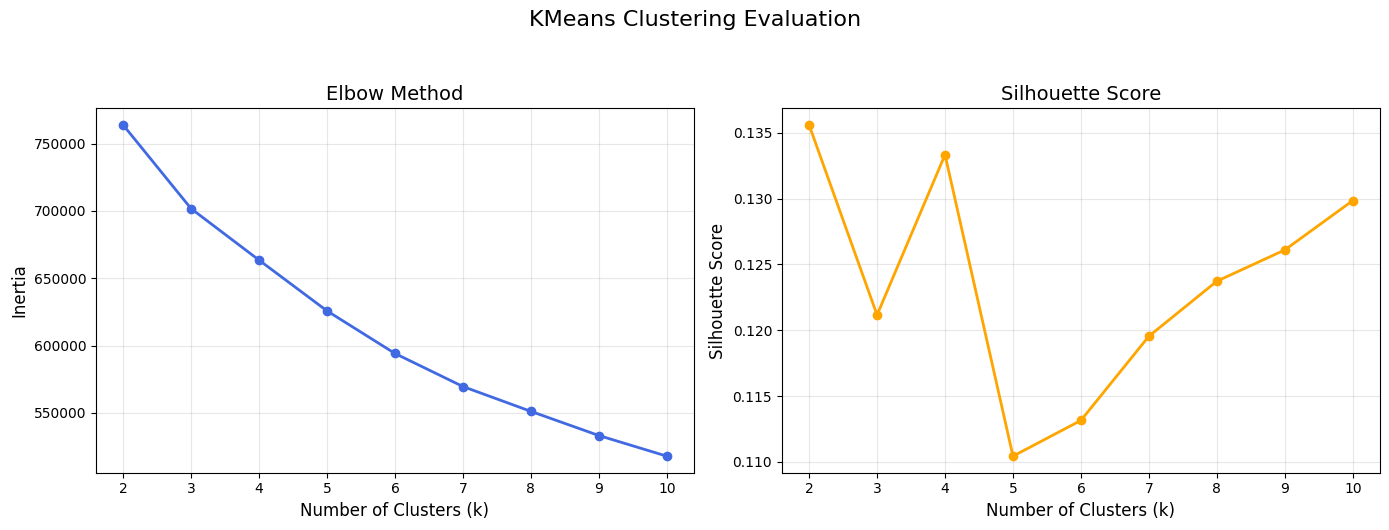

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot (Inertia vs. Number of Clusters)
axes[0].plot(K_RANGE, inertias, marker='o', color='royalblue', linewidth=2)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14)
axes[0].grid(alpha=0.3)
axes[0].tick_params(axis='both', which='major', labelsize=10)

# Silhouette plot
axes[1].plot(K_RANGE, silhouette_scores, marker='o', color='orange', linewidth=2)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score', fontsize=14)
axes[1].grid(alpha=0.3)
axes[1].tick_params(axis='both', which='major', labelsize=10)

plt.suptitle('KMeans Clustering Evaluation', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

In our case, the elbow method does not allow us to determine an optimal number of clusters. We therefore chose to define K by maximising the silhouette score, which led to **K=2**. However, the result remains disappointing, with a silhouette score of less than 0.2, indicating very poor clustering quality. It therefore appears that the K-means method is not suitable for our use case.

In [41]:
# Parameters
N_CLUSTERS = 2
RANDOM_STATE = 42

# Initialize and fit KMeans
kmeans_final = KMeans(
    n_clusters=N_CLUSTERS,
    n_init=20,
    max_iter=300,
    random_state=RANDOM_STATE
)

# Fit the model and assign cluster labels
df['cluster'] = kmeans_final.fit_predict(X_scaled)

# Display cluster distribution
cluster_counts = df['cluster'].value_counts().sort_index()
print(cluster_counts)

cluster
0    57087
1    72793
Name: count, dtype: int64


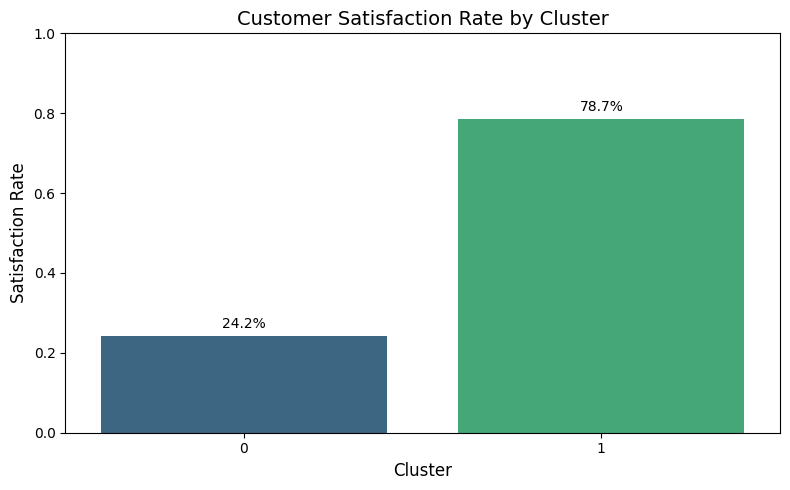

In [42]:
# Satisfaction rate per cluster
cluster_satisfaction = (
    df.groupby('cluster')['satisfaction']
    .mean()
    .sort_index()
)

# Plot satisfaction rate by cluster
plt.figure(figsize=(8, 5))

sns.barplot(
    x=cluster_satisfaction.index,
    y=cluster_satisfaction.values,
    palette='viridis'
)

# Labels and title
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Satisfaction Rate', fontsize=12)
plt.title('Customer Satisfaction Rate by Cluster', fontsize=14)
plt.ylim(0, 1)

# Annotate bars with exact percentage
for i, rate in enumerate(cluster_satisfaction.values):
    plt.text(i, rate + 0.02, f"{rate:.1%}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [43]:
# Compute cluster profiles: mean feature values per cluster
cluster_profiles = (
    df
    .groupby('cluster')[X.columns]
    .mean()
    .round(3)
    .sort_index()
)

# Display cluster profiles
print(cluster_profiles.T)

cluster                               0         1
CustomerType                      0.279     0.108
Age                              37.218    41.161
TypeofTravel                      0.331     0.292
FlightDistance                  1996.91  1969.253
Seatcomfort                        2.39     3.191
DepartureArrivaltimeconvenient    2.837     3.111
Foodanddrink                      2.579     3.066
Gatelocation                      2.946     3.025
Inflightwifiservice               2.532     3.812
Inflightentertainment             2.633     3.972
Onlinesupport                     2.637     4.212
EaseofOnlinebooking               2.396     4.316
Onboardservice                    2.777     4.005
Legroomservice                    2.899     3.946
Baggagehandling                   3.128      4.14
Checkinservice                    2.901     3.686
Cleanliness                       3.133     4.155
Onlineboarding                    2.489      4.03
ArrivalDelayinMinutes            17.689    12.972


Although the K-means clustering divided the customers into two groups, the low silhouette score *(<0.2)* suggests that these clusters are poorly defined and do not accurately represent the natural segments within the data. Nevertheless, some patterns can be observed that may provide initial insights.

- **Cluster 0** appears to comprise younger passengers *(average age approximately 37)* and a smaller proportion of business-class travellers *(approximately 28%)*, who give lower ratings for almost all service attributes, such as seat comfort, food and drink, in-flight entertainment and onboard service. These customers also experience slightly higher arrival delays *(approximately 17.7 minutes)*.

- **Cluster 1** includes slightly older passengers *(average age approximately 41)*, a higher proportion of business-class travellers *(approximately 60%)*, and consistently higher ratings for all service-related features, particularly digital services such as online booking, online support, in-flight Wi-Fi and online boarding. These customers also experience slightly fewer arrival delays *(on average, 13 minutes)*.

**Business implications:** Although the clusters are poorly defined, the general trend aligns with expectations: business-class and older passengers tend to rate services more highly, whereas younger or economy-class passengers tend to be less satisfied. This suggests that investments in digital and in-flight services may have a different impact on different customer segments.

**Limitations:** The poor clustering quality means these segments are unreliable for operational decisions. The low silhouette score indicates high overlap between clusters, meaning that many customers do not clearly belong to one cluster or another. Therefore, actionable strategies based on this segmentation should be approached with caution.

#### Principal Component Analysis *(PCA)*

Explained variance ratio per component: [0.187 0.119]
Total variance explained: 30.6%


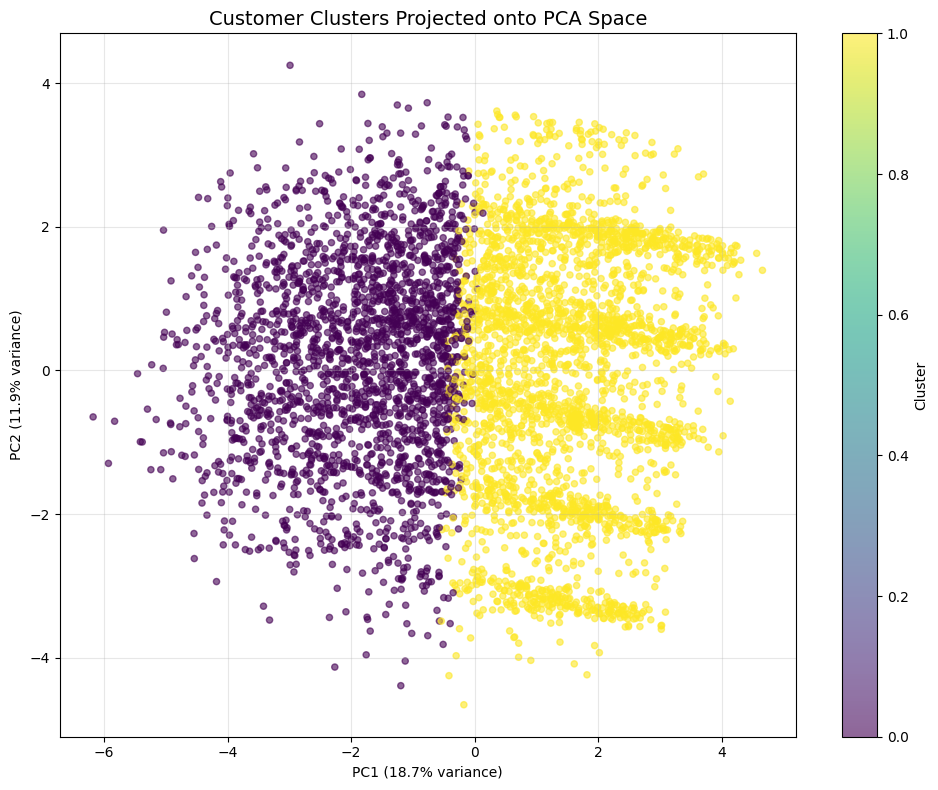

In [44]:
# Parameters
N_COMPONENTS = 2
SAMPLE_SIZE = 5_000
RANDOM_STATE = 42

# PCA Transformation
pca = PCA(n_components=N_COMPONENTS, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

# Explained variance
explained_var = pca.explained_variance_ratio_
print(f"Explained variance ratio per component: {explained_var.round(3)}")
print(f"Total variance explained: {explained_var.sum():.1%}")

# Subsampling for Plotting
rng = np.random.default_rng(RANDOM_STATE)
sample_idx = rng.choice(X_pca.shape[0], size=SAMPLE_SIZE, replace=False)

# Scatter Plot in PCA Space
plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    X_pca[sample_idx, 0],
    X_pca[sample_idx, 1],
    c=df.loc[df.index[sample_idx], 'cluster'],  # color by cluster
    cmap='viridis',
    alpha=0.6,
    s=20
)

# Labels and Title
plt.xlabel(f"PC1 ({explained_var[0]:.1%} variance)")
plt.ylabel(f"PC2 ({explained_var[1]:.1%} variance)")
plt.title("Customer Clusters Projected onto PCA Space", fontsize=14)

# Colorbar for clusters
cbar = plt.colorbar(scatter)
cbar.set_label("Cluster")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

PCA also does not seem suitable for visualisation or clustering in our case. Indeed, the total variance explained by a 2D projection is very limited, at around 30%, which does not allow the data structure to be represented correctly.

#### Hierarchical Clustering

For more detailed and robust segmentation, we can consider a hierarchical clustering approach, which allows complex structures in the data to be captured.

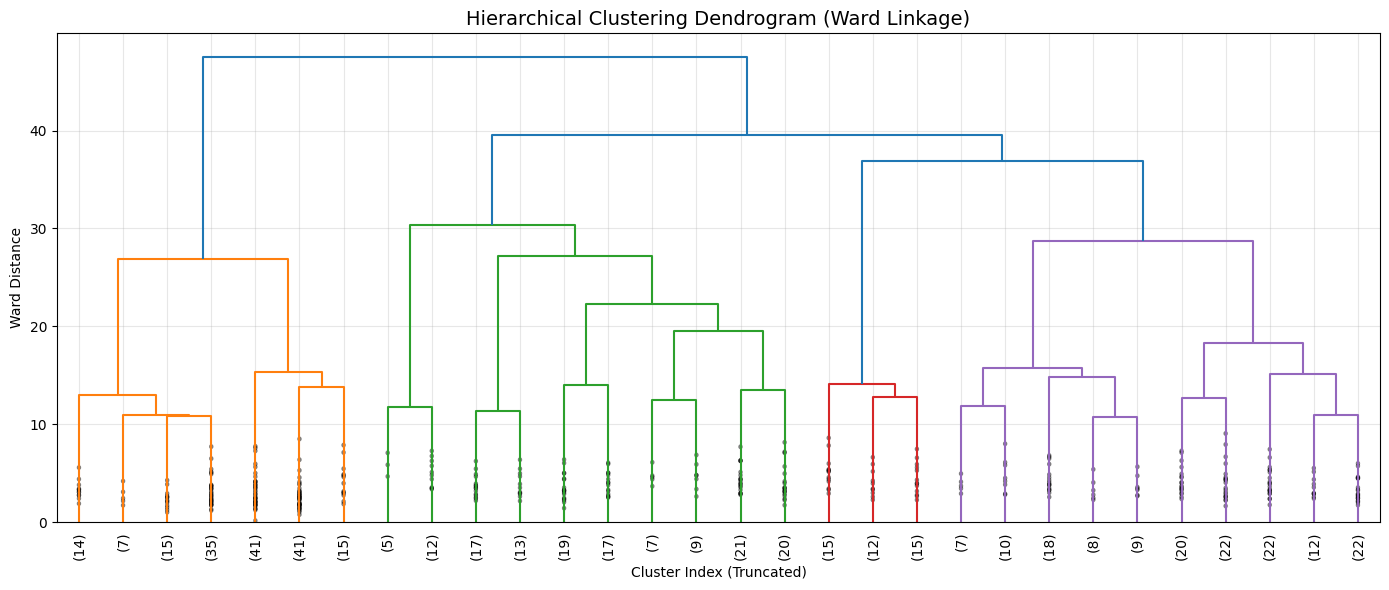

In [45]:
# Parameters
DENDROGRAM_SAMPLE_SIZE = 500  # Number of points to subsample for dendrogram
RANDOM_STATE = 42
LINKAGE_METHOD = "ward"
MAX_CLUSTERS_DISPLAYED = 30   # Maximum number of clusters to show (truncated)

# Subsampling for Dendrogram
rng = np.random.default_rng(RANDOM_STATE)
sample_idx = rng.choice(X_scaled.shape[0], size=DENDROGRAM_SAMPLE_SIZE, replace=False)
X_dendrogram = X_scaled[sample_idx]

# Hierarchical Clustering
linkage_matrix = linkage(X_dendrogram, method=LINKAGE_METHOD)

# Plot Dendrogram
plt.figure(figsize=(14, 6))

dendrogram(
    linkage_matrix,
    truncate_mode="lastp",            # Show only the last p merged clusters
    p=MAX_CLUSTERS_DISPLAYED,         # Maximum clusters displayed
    leaf_rotation=90,                 # Rotate x-axis labels for readability
    leaf_font_size=10,
    show_contracted=True              # Show contracted branches
)

# Titles and labels
plt.title("Hierarchical Clustering Dendrogram (Ward Linkage)", fontsize=14)
plt.xlabel("Cluster Index (Truncated)")
plt.ylabel("Ward Distance")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


This dendrogram clearly shows a structure with potentially **four** major groupings, indicated by the blue colored branches. The dendrogram looks relatively clean and shows distinct, well-separated merges, which suggests Ward Linkage might be a **good fit**.

However, we are unsure about the underlying structure or suspect non-convex/variable-density clusters.

#### PCA → UMAP → HDBSCAN

Our recommended approach combines the strengths of dimensionality reduction and density-based clustering:

- **PCA:** Reduces noise and compresses the dataset while retaining 95% of the total variance.

- **UMAP:** Captures both local and global structures in the data, improving the separation between potential clusters.

- **HDBSCAN:** A density-based clustering algorithm that automatically identifies the optimal number of clusters without requiring a pre-specified K.

This pipeline leverages PCA and UMAP for robust feature representation, followed by HDBSCAN to detect natural groupings in the data, offering a more flexible and accurate segmentation compared to traditional methods like K-means.

In [46]:
# Parameters
VARIANCE_THRESHOLD = 0.95  # Retain 95% of variance
RANDOM_STATE = 42

# PCA with variance retention
pca_full = PCA(
    n_components=VARIANCE_THRESHOLD,
    svd_solver="full",
    random_state=RANDOM_STATE
)

# Fit PCA and transform the data
X_pca_reduced = pca_full.fit_transform(X_scaled)

# Explained variance
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Print summary
print(f"Original number of features: {X_scaled.shape[1]}")
print(f"Reduced number of components to retain ≥ {VARIANCE_THRESHOLD:.0%} variance: {X_pca_reduced.shape[1]}")
print(f"Total variance explained: {cumulative_var[-1]:.1%}")

Original number of features: 22
Reduced number of components to retain ≥ 95% variance: 17
Total variance explained: 95.2%


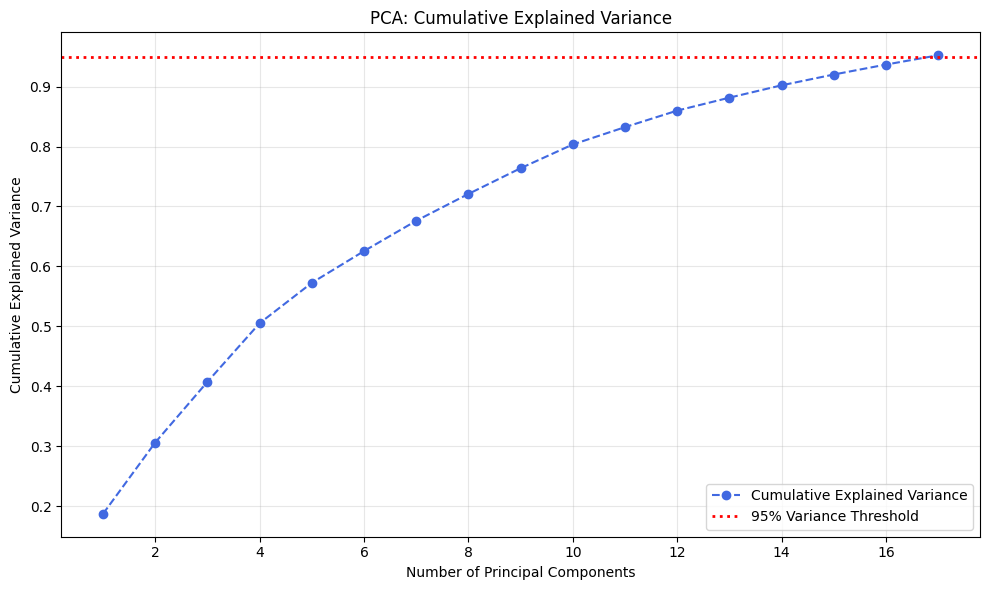

In [47]:
plt.figure(figsize=(10, 6))

plt.plot(
    range(1, len(cumulative_var) + 1),
    cumulative_var,
    marker='o',
    linestyle='--',
    color='royalblue',
    label='Cumulative Explained Variance'
)

# Highlight the variance threshold
plt.axhline(
    y=VARIANCE_THRESHOLD,
    color='red',
    linestyle=':',
    linewidth=2,
    label=f'{VARIANCE_THRESHOLD:.0%} Variance Threshold'
)

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [48]:
print("Fitting UMAP...")

# Parameters
N_NEIGHBORS = 15
MIN_DIST = 0.1
N_COMPONENTS = 2
UMAP_SAMPLE_SIZE = 30_000
RANDOM_STATE = 42

# Subsample data for UMAP (UMAP can be computationally expensive)
rng = np.random.default_rng(RANDOM_STATE)
sample_idx = rng.choice(X_pca_reduced.shape[0], size=UMAP_SAMPLE_SIZE, replace=False)
X_sample = X_pca_reduced[sample_idx]

# Initialize UMAP reducer
umap_reducer = umap.UMAP(
    n_neighbors=N_NEIGHBORS,
    min_dist=MIN_DIST,
    n_components=N_COMPONENTS,
    metric="euclidean",
    random_state=RANDOM_STATE,
    n_jobs=1
)

# Fit and transform the subsampled data
X_umap = umap_reducer.fit_transform(X_sample)

print(f"UMAP embedding completed. Shape: {X_umap.shape}")

Fitting UMAP...
UMAP embedding completed. Shape: (30000, 2)


In [49]:
# HDBSCAN Clustering on UMAP Embedding
clusterer_umap = hdbscan.HDBSCAN(
    min_cluster_size=1000,           # Minimum points to form a cluster
    min_samples=20,                  # Minimum samples in the neighborhood for a point to be core
    metric='euclidean',
    cluster_selection_method='eom'   # Excess of mass method
)

# Fit and predict cluster labels
umap_hdbscan_labels = clusterer_umap.fit_predict(X_umap)

# Summary statistics
# Unique clusters (excluding noise)
cluster_labels_unique = set(umap_hdbscan_labels)
n_clusters_umap = len(cluster_labels_unique) - (1 if -1 in cluster_labels_unique else 0)

# Noise points
n_noise_umap = np.sum(umap_hdbscan_labels == -1)
noise_ratio = n_noise_umap / len(umap_hdbscan_labels) * 100

print("HDBSCAN Clustering Results:")
print(f"  Number of clusters found (excluding noise): {n_clusters_umap}")
print(f"  Number of noise points: {n_noise_umap} ({noise_ratio:.1f}%)\n")

# Cluster distribution including noise
cluster_counts = pd.Series(umap_hdbscan_labels).value_counts().sort_index()
print("Cluster distribution (including noise, -1 = noise):")
print(cluster_counts)

HDBSCAN Clustering Results:
  Number of clusters found (excluding noise): 7
  Number of noise points: 0 (0.0%)

Cluster distribution (including noise, -1 = noise):
0    2157
1    7407
2    3169
3    2093
4    3263
5    9068
6    2843
Name: count, dtype: int64


In [50]:
# Assign HDBSCAN cluster labels to the sampled DataFrame
umap_sample_df = df.iloc[sample_idx].copy()
umap_sample_df['umap_cluster'] = umap_hdbscan_labels

# Exclude noise for cluster-level analysis
clusters_only = umap_sample_df[umap_sample_df['umap_cluster'] != -1]

# Calculate satisfaction rate per cluster
umap_satisfaction = clusters_only.groupby('umap_cluster')['satisfaction'].mean()
cluster_sizes = clusters_only['umap_cluster'].value_counts().sort_index()

print("Satisfaction Rate per Cluster (HDBSCAN):")
for cluster in umap_satisfaction.index:
    rate = umap_satisfaction.loc[cluster]
    count = cluster_sizes.loc[cluster]
    print(f"  Cluster {cluster}: {rate:.1%} satisfied (n={count})")

# Analyze noise points separately
n_noise = (umap_sample_df['umap_cluster'] == -1).sum()
if n_noise > 0:
    noise_rate = umap_sample_df.loc[umap_sample_df['umap_cluster'] == -1, 'satisfaction'].mean()
    print(f"  Noise (-1): {noise_rate:.1%} satisfied (n={n_noise})")

Satisfaction Rate per Cluster (HDBSCAN):
  Cluster 0: 42.4% satisfied (n=2157)
  Cluster 1: 47.9% satisfied (n=7407)
  Cluster 2: 14.6% satisfied (n=3169)
  Cluster 3: 38.5% satisfied (n=2093)
  Cluster 4: 45.8% satisfied (n=3263)
  Cluster 5: 68.4% satisfied (n=9068)
  Cluster 6: 99.3% satisfied (n=2843)


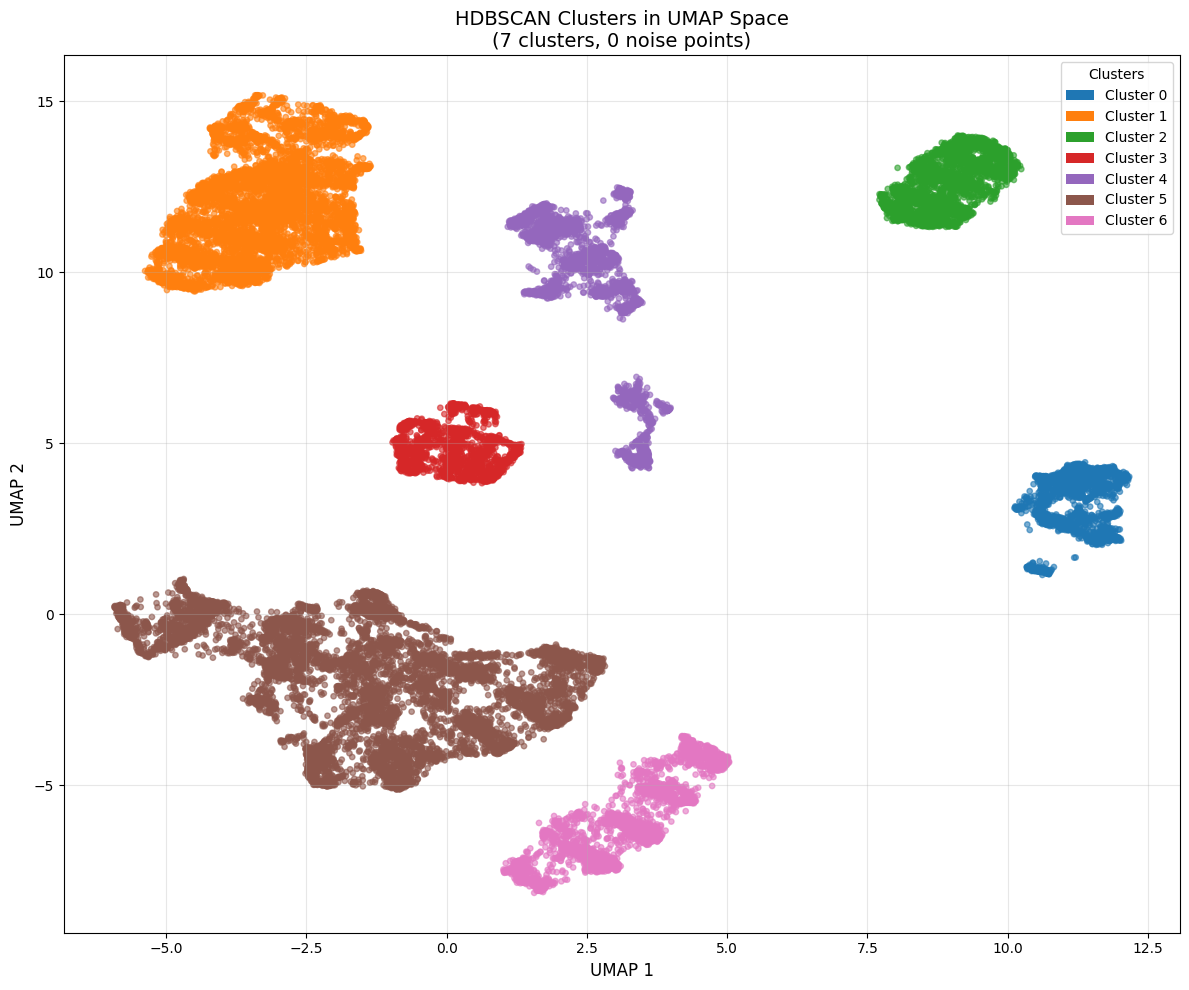

In [51]:
# Unique cluster labels
unique_labels = np.unique(umap_hdbscan_labels)

# Color mapping
# Use tab10 for clusters, grey for noise
cmap = plt.cm.tab10
colors = [cmap(i % 10) for i in range(len(unique_labels))]
color_map = {label: colors[i] if label != -1 else (0.7, 0.7, 0.7, 1.0)
             for i, label in enumerate(unique_labels)}

# Assign colors to each point based on cluster
point_colors = [color_map[label] for label in umap_hdbscan_labels]

# Plot UMAP embedding
plt.figure(figsize=(12, 10))
plt.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    c=point_colors,
    s=15,
    alpha=0.6
)

plt.xlabel('UMAP 1', fontsize=12)
plt.ylabel('UMAP 2', fontsize=12)
plt.title(f'HDBSCAN Clusters in UMAP Space\n({n_clusters_umap} clusters, {n_noise_umap} noise points)', fontsize=14)

# Legend
legend_elements = [
    Patch(facecolor=color_map[label],
          label=f'Cluster {label}' if label != -1 else 'Noise (-1)')
    for label in sorted(unique_labels)
]

plt.legend(handles=legend_elements, loc='upper right', title='Clusters', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

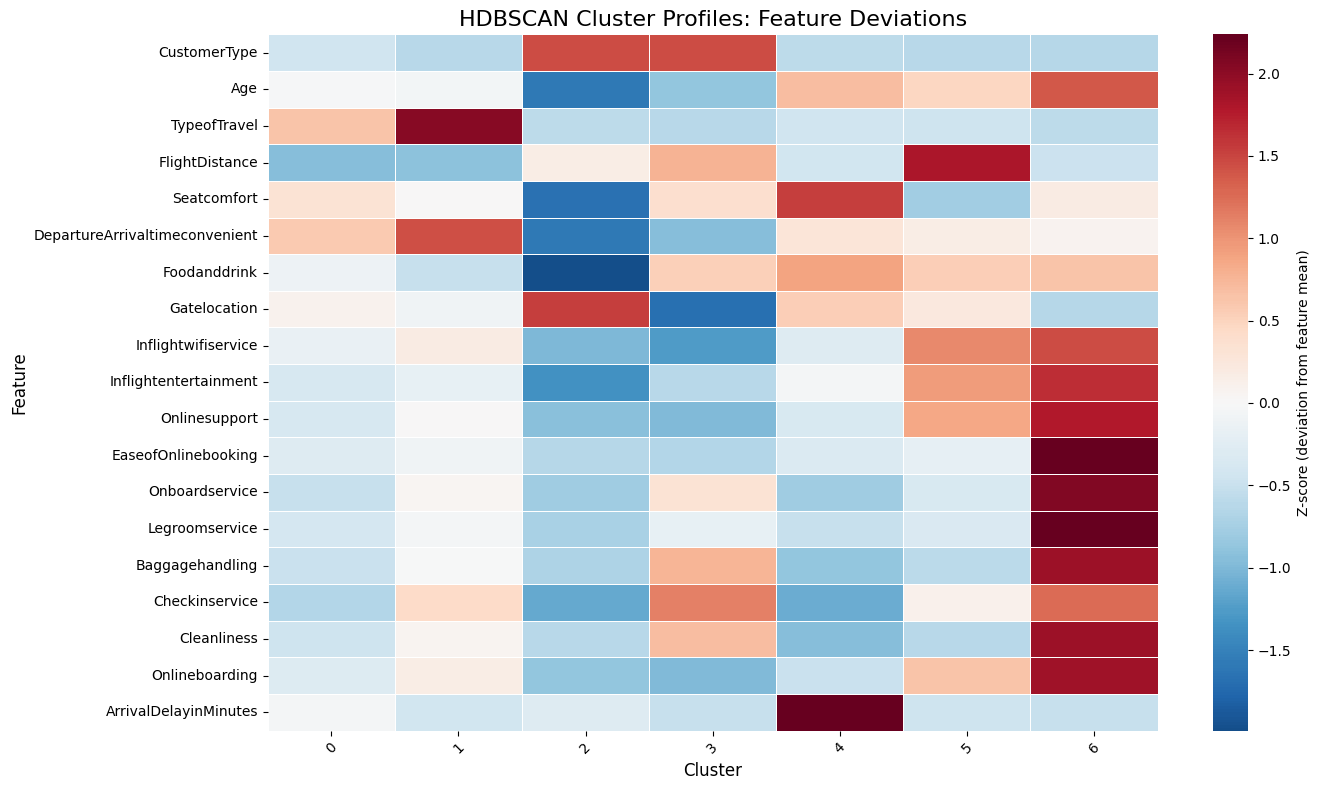

In [52]:
# Select clusters (exclude noise)
clusters_df = umap_sample_df[umap_sample_df['umap_cluster'] != -1].copy()
feature_cols = X.select_dtypes(include=np.number).columns.tolist()

# Compute mean feature values per cluster
cluster_means = clusters_df.groupby('umap_cluster')[feature_cols].mean()

# Normalize features (Z-score) for relative comparison
cluster_means_normalized = (cluster_means - cluster_means.mean()) / cluster_means.std()
cluster_means_normalized = cluster_means_normalized.astype(float)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    cluster_means_normalized.T,      # Transpose: features on y-axis, clusters on x-axis
    cmap='RdBu_r',                   # Red = above mean, Blue = below mean
    center=0,                        # Zero-centered for deviations
    annot=False,                     # Optionally, set True to annotate values
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={'label': 'Z-score (deviation from feature mean)'}
)

# Labels and formatting
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('HDBSCAN Cluster Profiles: Feature Deviations', fontsize=16)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

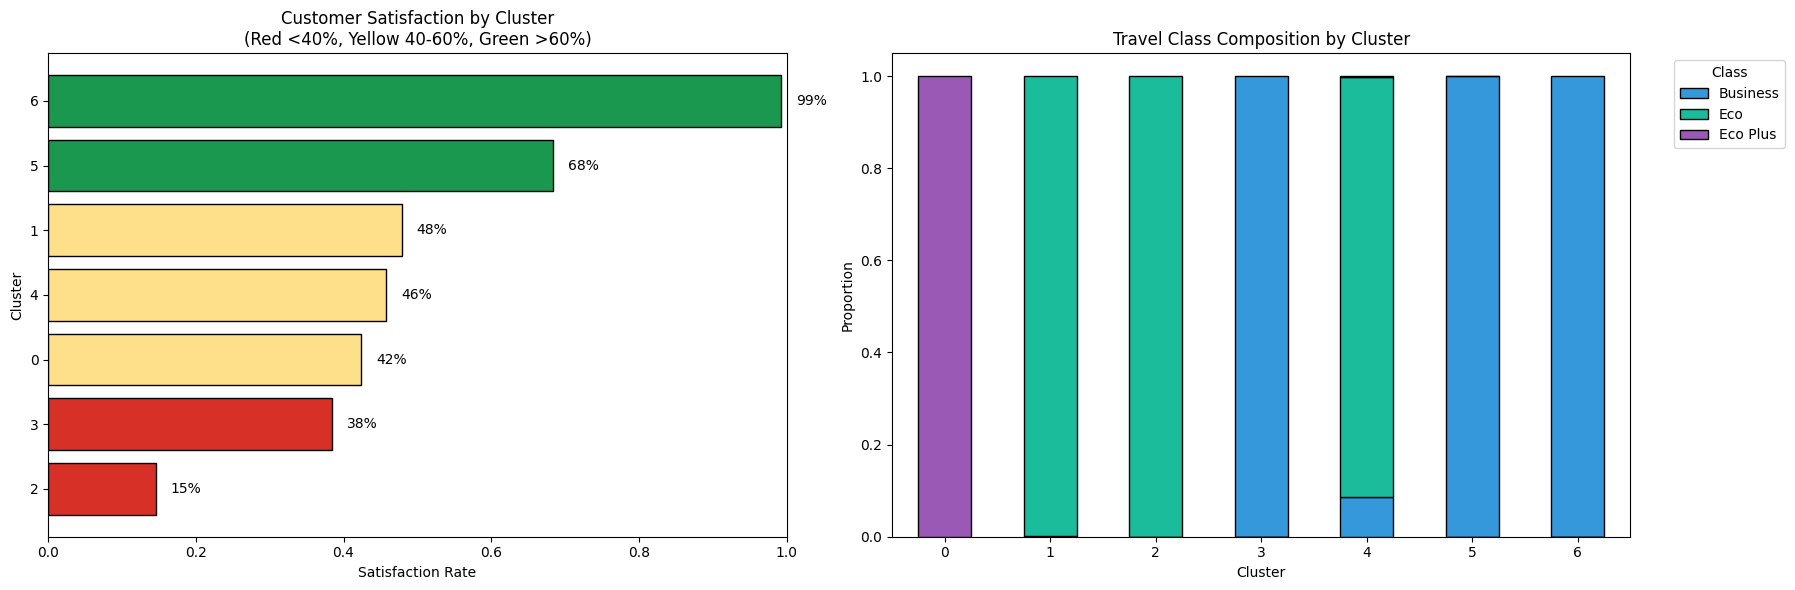

In [53]:
# Aggregate satisfaction per cluster
satisfaction_by_cluster = (
    clusters_df.groupby('umap_cluster')
    .agg(
        Satisfaction_Rate=('satisfaction', 'mean'),
        Size=('satisfaction', 'count')
    )
    .round(3)
    .sort_values('Satisfaction_Rate')
)

# Define color mapping based on satisfaction rate
def satisfaction_color(rate):
    if rate < 0.4:
        return '#d73027'  # Red: At-Risk
    elif rate < 0.6:
        return '#fee08b'  # Yellow: Neutral
    else:
        return '#1a9850'  # Green: Promoter

colors = satisfaction_by_cluster['Satisfaction_Rate'].apply(satisfaction_color)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Horizontal Bar Chart: Satisfaction Rate
bars = axes[0].barh(
    satisfaction_by_cluster.index.astype(str),
    satisfaction_by_cluster['Satisfaction_Rate'],
    color=colors,
    edgecolor='black'
)
axes[0].set_xlabel('Satisfaction Rate')
axes[0].set_ylabel('Cluster')
axes[0].set_title('Customer Satisfaction by Cluster\n(Red <40%, Yellow 40-60%, Green >60%)')
axes[0].set_xlim(0, 1)

# Annotate bars with percentages
for bar, rate in zip(bars, satisfaction_by_cluster['Satisfaction_Rate']):
    axes[0].text(
        rate + 0.02,
        bar.get_y() + bar.get_height()/2,
        f'{rate:.0%}',
        va='center',
        fontsize=10
    )

# Stacked Bar Chart: Travel Class Composition
# Identify one-hot encoded class columns
class_cols = [col for col in clusters_df.columns if col.startswith('Class_')]

# Compute mean proportion per cluster
class_comp = clusters_df.groupby('umap_cluster')[class_cols].mean().sort_index()
class_comp.columns = [col.replace('Class_', '') for col in class_comp.columns]  # clean names

# Plot stacked bar chart
class_comp.plot(
    kind='bar', stacked=True, ax=axes[1],
    color=['#3498db', '#1abc9c', '#9b59b6'],  # distinct colors for classes
    edgecolor='black'
)
axes[1].set_title('Travel Class Composition by Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Proportion')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [54]:
# Cluster Risk Assessment
for cluster_id, row in satisfaction_by_cluster.iterrows():
    # Assign risk category based on satisfaction rate
    if row['Satisfaction_Rate'] < 0.4:
        status = "AT-RISK"
    elif row['Satisfaction_Rate'] < 0.6:
        status = "NEUTRAL"
    else:
        status = "PROMOTER"

    # Print cluster summary
    print(
        f"  Cluster {cluster_id}: "
        f"{row['Satisfaction_Rate']:.1%} satisfied "
        f"({int(row['Size'])} customers) - {status}"
    )

  Cluster 2: 14.6% satisfied (3169 customers) - AT-RISK
  Cluster 3: 38.5% satisfied (2093 customers) - AT-RISK
  Cluster 0: 42.4% satisfied (2157 customers) - NEUTRAL
  Cluster 4: 45.8% satisfied (3263 customers) - NEUTRAL
  Cluster 1: 47.9% satisfied (7407 customers) - NEUTRAL
  Cluster 5: 68.4% satisfied (9068 customers) - PROMOTER
  Cluster 6: 99.3% satisfied (2843 customers) - PROMOTER


Based on the percentage of satisfied customers in each cluster, the segments can be categorised as `AT RISK`, `NEUTRAL` or `PROMOTER`:

1. **AT-RISK Customers**

- Cluster 2 *(14.6% satisfied, 3,169 customers)* and Cluster 3 *(38.5% satisfied, 2,093 customers)*

- These segments show low satisfaction, indicating a high likelihood of churn. Immediate attention is required to identify pain points (such as service quality, digital experience, or comfort) and implement targeted improvements to retain these customers.

2. **NEUTRAL Customers**

- Clusters 0, 1, and 4 with satisfaction between 42–48%

- These customers are moderately satisfied but not highly engaged. Business strategies could focus on upselling, loyalty programs, or small service enhancements to increase satisfaction and move them towards promoter status.

3. **PROMOTER Customers**

- Cluster 5 *(68.4% satisfied, 9,068 customers)* and Cluster 6 *(99.3% satisfied, 2,843 customers)*

- These segments are highly satisfied and likely to recommend the airline. Maintaining their experience through premium services, loyalty rewards, and personalized communication can strengthen retention and advocacy.

**Business implication:** This segmentation provides a clear framework for prioritising actions: address at-risk clusters first to reduce churn; nurture neutral clusters to boost satisfaction; and reinforce promoter clusters to maximise loyalty and positive word-of-mouth.

In [55]:
# Customer Segmentation Summary
summary_data = []

# Identify the one-hot encoded class columns
class_cols = [col for col in clusters_df.columns if col.startswith('Class_')]

for cluster_id in sorted(clusters_df['umap_cluster'].unique()):
    cluster_data = clusters_df[clusters_df['umap_cluster'] == cluster_id]

    size = len(cluster_data)
    sat_rate = cluster_data['satisfaction'].mean()
    loyal_pct = cluster_data['CustomerType'].mean()

    # Business/Eco/Eco Plus percentages based on one-hot encoded columns
    business_class_pct = cluster_data['Class_Business'].mean() if 'Class_Business' in cluster_data else 0.0
    eco_class_pct = cluster_data['Class_Eco'].mean() if 'Class_Eco' in cluster_data else 0.0
    eco_plus_class_pct = cluster_data['Class_Eco Plus'].mean() if 'Class_Eco Plus' in cluster_data else 0.0

    business_travel_pct = (cluster_data['TypeofTravel'] == 0).mean() if 'TypeofTravel' in cluster_data else 0.0
    avg_age = cluster_data['Age'].mean() if 'Age' in cluster_data else np.nan
    avg_service = cluster_data[ordinal_features].mean().mean()


    # Append summary for this cluster
    summary_data.append({
        'Cluster': cluster_id,
        'Size': size,
        'Satisfaction': f"{sat_rate:.0%}",
        'Loyal %': f"{loyal_pct:.0%}",
        'Business Class %': f"{business_class_pct:.0%}",
        'Eco Class %': f"{eco_class_pct:.0%}",
        'Eco Plus Class %': f"{eco_plus_class_pct:.0%}",
        'Avg Age': f"{avg_age:.0f}" if not np.isnan(avg_age) else "N/A",
        'Avg Service Rating': f"{avg_service:.1f}/5"
    })

# Convert to DataFrame
summary_df = pd.DataFrame(summary_data)

# Display summary
print(summary_df.to_string(index=False))

 Cluster  Size Satisfaction Loyal % Business Class % Eco Class % Eco Plus Class % Avg Age Avg Service Rating
       0  2157          42%      9%               0%          0%             100%      39              3.2/5
       1  7407          48%      0%               0%        100%               0%      38              3.3/5
       2  3169          15%    100%               0%        100%               0%      29              2.9/5
       3  2093          39%    100%             100%          0%               0%      33              3.3/5
       4  3263          46%      3%               9%         91%               0%      43              3.1/5
       5  9068          68%      0%             100%          0%               0%      42              3.3/5
       6  2843          99%      0%             100%          0%               0%      48              4.0/5


The clustering results reveal distinct customer segments that differ significantly in terms of satisfaction, loyalty, demographics and service ratings. This information can be used to inform targeted business strategies:

1. **High-Value Loyal Customers** *(Cluster 6)*

- Size: 2,843
- Satisfaction: 99%, Average service rating: 4.0/5
- Predominantly business-class travelers (100%) with an older average age (48)
- **Implication:** This segment is highly satisfied and loyal. Retention strategies, premium offers, and personalized services should focus here to maintain loyalty and maximize revenue.

2. **Moderately Satisfied Business Travelers** *(Cluster 5)*

- Size: 9,068
- Satisfaction: 68%, Average service rating: 3.3/5
- Entirely business class with an older demographic (avg age 42)
- **Implication:** Although satisfied, there is room to increase satisfaction and retention by enhancing comfort, digital services, or loyalty programs.

3. Younger, Less Satisfied Economy Travelers (Cluster 2)

- Size: 3,169
- Satisfaction: 15%, Average service rating: 2.9/5
- Predominantly younger travelers (avg age 29), mostly loyal
- **Implication:** This segment is highly dissatisfied. Business should investigate key pain points (likely related to service quality or digital experience) and implement improvements to reduce churn.

4. **Mixed Segments** *(Clusters 0, 1, 3, 4)*

- These clusters show moderate satisfaction (38–48%) and varied class composition.
- Average service ratings range from 3.1–3.3/5.
- **Implication:** These segments represent customers with mixed experiences. Targeted interventions could include enhancing onboard services, digital convenience, and tailored promotions based on travel class and age.

**Overall business insight:**

- **Premium segments** *(business class, older travelers)* are generally more satisfied, suggesting that investments in service and comfort for these groups pay off.

- **Younger economy-class travelers** exhibit low satisfaction, indicating a key area for improvement to reduce dissatisfaction and churn.

- **Segmentation enables targeted strategies:** loyalty programs, service improvements, and personalized offers can be aligned with the characteristics of each cluster for maximum business impact.